DSEM Assignment 3</br>
Rhea Bajpai

# **Advertisement Click Prediction**
**Abstract**<br>

Advertisement click prediction is a data science problem that aims to predict if a user will click on an online advertisement or not. The prediction is made based on a variety of features related to the user, the advertisement, and in which the ad is displayed.

##Data Preprocessing Tools

In [1]:
#installs both eli5 and shap Python packages for interpreting and debugging machine learning models.
!pip install eli5 shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import packages
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
#The code reads in train and test data sets, drops the 'user_id' column.
data_train = pd.read_csv('https://raw.githubusercontent.com/Rhea3110/DSEM/main/Ad_click_prediction_train.csv',index_col=0)
data_train=data_train.drop('user_id',axis=1)
data_train=data_train.drop('DateTime',axis=1)
data_train=data_train.drop('user_group_id',axis=1)

#data_train=data_train.drop('session_id',axis=1)
print(data_train.head().to_markdown())
print(f"Length / No of rows in train set: {data_train.shape[0]}")
print(f"Width / No of columns in train set: {data_train.shape[1]}")
data_test = pd.read_csv('https://raw.githubusercontent.com/Rhea3110/DSEM/main/Ad_Click_prediciton_test.csv',index_col=0)
data_test=data_test.drop('user_id',axis=1)
data_test=data_test.drop('DateTime',axis=1)
data_test=data_test.drop('user_group_id',axis=1)

#data_test=data_test.drop('session_id',axis=1)
print(data_test.head().to_markdown())
print(f"Length / No of rows in test set: {data_test.shape[0]}")
print(f"Width / No of columns in test set: {data_test.shape[1]}")

|   session_id | product   |   campaign_id |   webpage_id |   product_category_1 |   product_category_2 | gender   |   age_level |   user_depth |   city_development_index |   var_1 |   is_click |
|-------------:|:----------|--------------:|-------------:|---------------------:|---------------------:|:---------|------------:|-------------:|-------------------------:|--------:|-----------:|
|       140690 | C         |        359520 |        13787 |                    4 |                  nan | Female   |           4 |            3 |                        3 |       0 |          0 |
|       333291 | C         |        105960 |        11085 |                    5 |                  nan | Female   |           2 |            2 |                      nan |       0 |          0 |
|       129781 | C         |        359520 |        13787 |                    4 |                  nan | Female   |           2 |            2 |                      nan |       0 |          0 |
|       464848 | I  

In [4]:
print(data_train.columns)
print(data_test.columns)

Index(['product', 'campaign_id', 'webpage_id', 'product_category_1',
       'product_category_2', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click'],
      dtype='object')
Index(['product', 'campaign_id', 'webpage_id', 'product_category_1',
       'product_category_2', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1'],
      dtype='object')


In [5]:
#prints information about the data_train DataFrame, identifies numerical and categorical columns.
print(data_train.info())
numericCols = data_train.select_dtypes("number").columns
categoricCols = data_train.select_dtypes("object").columns
numericCols= list(set(numericCols))
categoricCols= list(set(categoricCols))
print(f"Numerical Columns: {numericCols}")
print(f"Categorical Columns: {categoricCols}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463291 entries, 140690 to 45023
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   product                 463291 non-null  object 
 1   campaign_id             463291 non-null  int64  
 2   webpage_id              463291 non-null  int64  
 3   product_category_1      463291 non-null  int64  
 4   product_category_2      97437 non-null   float64
 5   gender                  445048 non-null  object 
 6   age_level               445048 non-null  float64
 7   user_depth              445048 non-null  float64
 8   city_development_index  338162 non-null  float64
 9   var_1                   463291 non-null  int64  
 10  is_click                463291 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 42.4+ MB
None
Numerical Columns: ['age_level', 'product_category_1', 'var_1', 'campaign_id', 'product_category_2', 'user_depth', 

In [6]:
# count the number of missing values in the current dataset.
print("Missing data in training set:\n",data_train.isnull().sum())
print('*'*35)
print("Missing data in test set:\n",data_test.isnull().sum())

Missing data in training set:
 product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        365854
gender                     18243
age_level                  18243
user_depth                 18243
city_development_index    125129
var_1                          0
is_click                       0
dtype: int64
***********************************
Missing data in test set:
 product                       0
campaign_id                   0
webpage_id                    0
product_category_1            0
product_category_2        76171
gender                     5684
age_level                  5684
user_depth                 5684
city_development_index    34609
var_1                         0
dtype: int64


In this case i choose to drop rows with null column as I have tried testing the accuracy with imputation and the accuracy was not that great. Also 70,000 data points are enough to train a model for good accuracy

In [7]:
#remove any rows with missing values from the data_train and data_test dataframes.
data_train=data_train.dropna(axis=0, how='any', subset=None, inplace=False)
data_test=data_test.dropna(axis=0, how='any', subset=None, inplace=False)
#rechecking the count of null data in the current dataset  
print("Missing data in training set:\n",data_train.isnull().sum())
print('*'*35)
print("Missing data in test set:\n",data_test.isnull().sum())

Missing data in training set:
 product                   0
campaign_id               0
webpage_id                0
product_category_1        0
product_category_2        0
gender                    0
age_level                 0
user_depth                0
city_development_index    0
var_1                     0
is_click                  0
dtype: int64
***********************************
Missing data in test set:
 product                   0
campaign_id               0
webpage_id                0
product_category_1        0
product_category_2        0
gender                    0
age_level                 0
user_depth                0
city_development_index    0
var_1                     0
dtype: int64


In [8]:
print(len(data_train))

72660


In [9]:
#split the data_train and data_test dataframes into separate predictor variable (X) and target variable (y) dataframes for use in machine learning models.
xtrain = data_train.iloc[:, 0:-1]
ytrain = data_train.iloc[:, -1]
xtest = data_test.iloc[:, :]


<b>One-hot encoding and dummy encoding</b> are techniques used to convert categorical variables into numerical values that can be used in machine learning algorithms. When using one-hot encoding, each unique category in the original dataset is converted into a binary vector, where only one element is "on" or "hot", and the rest are "off" or "cold". The resulting vector represents the original category as a numerical value that can be easily processed by machine learning algorithms. In the context of a dataframe, "df_dummies" likely refers to the resulting dataframe after performing one-hot encoding on the original categorical data.

In [10]:
#converts categorical columns in both the training and testing datasets into numerical columns using one-hot encoding and separates the resulting numerical and categorical columns for the training dataset.
xtrain = pd.get_dummies(xtrain)
xtest= pd.get_dummies(xtest)
numcatC = xtrain.select_dtypes("number").columns
categoricCol1 = xtrain.select_dtypes("object").columns
print(len(xtrain.columns))
print(len(xtest.columns))

20
20


In [11]:
print(xtrain.head().to_markdown())
print(xtest.head().to_markdown())
print(ytrain[:5])

|   session_id |   campaign_id |   webpage_id |   product_category_1 |   product_category_2 |   age_level |   user_depth |   city_development_index |   var_1 |   product_A |   product_B |   product_C |   product_D |   product_E |   product_F |   product_G |   product_H |   product_I |   product_J |   gender_Female |   gender_Male |
|-------------:|--------------:|-------------:|---------------------:|---------------------:|------------:|-------------:|-------------------------:|--------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|----------------:|--------------:|
|         2927 |        404347 |        53587 |                    1 |               146115 |           3 |            3 |                        3 |       1 |           0 |           0 |           0 |           0 |           0 |           0 |           0 |           0 |           1 |           0 |               1 |             0 

In [12]:
print(xtrain.columns)
print(xtest.columns)

Index(['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
       'age_level', 'user_depth', 'city_development_index', 'var_1',
       'product_A', 'product_B', 'product_C', 'product_D', 'product_E',
       'product_F', 'product_G', 'product_H', 'product_I', 'product_J',
       'gender_Female', 'gender_Male'],
      dtype='object')
Index(['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
       'age_level', 'user_depth', 'city_development_index', 'var_1',
       'product_A', 'product_B', 'product_C', 'product_D', 'product_E',
       'product_F', 'product_G', 'product_H', 'product_I', 'product_J',
       'gender_Female', 'gender_Male'],
      dtype='object')


<b>MinMaxScaler</b> is a normalization technique used to scale numerical data in a dataset to a specific range. In this method, each feature (column) in the dataset is scaled independently to a user-specified range, typically between 0 and 1, by subtracting the minimum value of the feature and dividing by the range of the feature. The formula for MinMaxScaler is:

x_scaled = (x - x_min) / (x_max - x_min)

where x is the original value of the feature, x_min is the minimum value of the feature, x_max is the maximum value of the feature, and x_scaled is the normalized value of the feature.

The purpose of using MinMaxScaler is to make sure that all the features in the dataset are on a similar scale, which can improve the performance of some machine learning algorithms. It can also prevent certain features from dominating the others due to their larger range of values. MinMaxScaler is commonly used in data preprocessing and is available in many popular Python machine learning libraries such as Scikit-learn.

In [13]:
# MinMaxScaler normalization to specific numerical columns in both the training and testing datasets.
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

xtrain[['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
        'age_level', 'user_depth', 'city_development_index',
       'var_1', 'product_A', 'product_B', 'product_C', 'product_D',
       'product_E', 'product_F', 'product_G', 'product_H', 'product_I',
       'product_J', 'gender_Female', 'gender_Male']] =min_max_scaler.fit_transform(xtrain[['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
        'age_level', 'user_depth', 'city_development_index',
       'var_1', 'product_A', 'product_B', 'product_C', 'product_D',
       'product_E', 'product_F', 'product_G', 'product_H', 'product_I',
       'product_J', 'gender_Female', 'gender_Male']]) 
xtest[['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
       'age_level', 'user_depth', 'city_development_index',
       'var_1', 'product_A', 'product_B', 'product_C', 'product_D',
       'product_E', 'product_F', 'product_G', 'product_H', 'product_I',
       'product_J', 'gender_Female', 'gender_Male']] =min_max_scaler.fit_transform (xtest[['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
     'age_level', 'user_depth', 'city_development_index',
       'var_1', 'product_A', 'product_B', 'product_C', 'product_D',
       'product_E', 'product_F', 'product_G', 'product_H', 'product_I',
       'product_J', 'gender_Female', 'gender_Male']])

In [14]:
#reate two new datasets: xtrain_2000 with 2000 samples from the xtrain dataset, and xtest_100 with 100 samples from the xtest dataset.
xtrain_1000 = shap.utils.sample(
    xtrain, 1000
)
xtest_1000 = shap.utils.sample(
    xtest, 1000
)
     

In [15]:
#creates a Pandas DataFrame named 'df' with a single column named 'is_click' containing the values from the 'ytrain' variable.
print(type(ytrain))
ytrain_pd= df = pd.DataFrame({'is_click': ytrain})


<class 'pandas.core.series.Series'>


In [16]:
print(len(xtrain))
print(len(ytrain))
print(len(xtrain.columns))
print(len(ytrain_pd.columns))

72660
72660
20
1


In [17]:
#trains a logistic regression model using 'xtrain' and 'ytrain_pd', and then fits an Ordinary Least Squares (OLS) regression model on the same data to calculate the p-values of the independent variables.
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(xtrain, ytrain_pd)
!pip install statsmodels
import statsmodels.api as sm
dependent_vars_train =ytrain_pd
model = sm.OLS(ytrain_pd, xtrain).fit()
pvalues = model.summary2().tables[1]['P>|t|']
print(pvalues.round(4))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
campaign_id               0.0416
webpage_id                0.3371
product_category_1        0.3112
product_category_2        0.7925
age_level                 0.3882
user_depth                0.1753
city_development_index    0.3192
var_1                     0.0003
product_A                 0.9417
product_B                 0.9262
product_C                 0.0017
product_D                 0.8605
product_E                 0.0000
product_F                 0.5071
product_G                 0.4674
product_H                 0.0000
product_I                 0.0013
product_J                 0.0000
gender_Female             0.0000
gender_Male               0.0000
Name: P>|t|, dtype: float64


In [18]:
#trains a decision tree classifier using 'xtrain' and 'ytrain', and then prints out the rules of the decision tree using 'export_text' function.
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
tree = export_text(model, feature_names=list(xtrain.columns))
print(tree)

|--- product_category_2 <= 0.29
|   |--- product_H <= 0.50
|   |   |--- product_I <= 0.50
|   |   |   |--- webpage_id <= 0.61
|   |   |   |   |--- product_D <= 0.50
|   |   |   |   |   |--- age_level <= 0.25
|   |   |   |   |   |   |--- product_category_1 <= 0.12
|   |   |   |   |   |   |   |--- var_1 <= 0.50
|   |   |   |   |   |   |   |   |--- city_development_index <= 0.50
|   |   |   |   |   |   |   |   |   |--- city_development_index <= 0.17
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- city_development_index >  0.17
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- city_development_index >  0.50
|   |   |   |   |   |   |   |   |   |--- city_development_index <= 0.83
|   |   |   |   |   |   |   |   |   |   |--- user_depth <= 0.75
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- user_depth >  0.75
|   |   |   |   |   |   |   |   |   |   |  

In [19]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init() #initializing the h2o library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 40 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_unknownUser_f3a1s1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.146 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [20]:
#concatenates 'xtrain' and 'ytrain_pd' and converts the resulting pandas dataframe to a H2OFrame object.
train_concat=pd.concat([xtrain,ytrain_pd],axis=1)
print(train_concat.head().to_markdown())
print("*"*300)
dtrain_h2o = h2o.H2OFrame(train_concat)
print(dtrain_h2o)
print(type(dtrain_h2o))

|   session_id |   campaign_id |   webpage_id |   product_category_1 |   product_category_2 |   age_level |   user_depth |   city_development_index |   var_1 |   product_A |   product_B |   product_C |   product_D |   product_E |   product_F |   product_G |   product_H |   product_I |   product_J |   gender_Female |   gender_Male |   is_click |
|-------------:|--------------:|-------------:|---------------------:|---------------------:|------------:|-------------:|-------------------------:|--------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|----------------:|--------------:|-----------:|
|         2927 |     0.970461  |     0.885302 |                    0 |             0.295466 |    0.5      |            1 |                 0.666667 |       1 |           0 |           0 |           0 |           0 |           0 |           0 |           0 |           0 |           1 |           0 |       

In [21]:
#dropping unwanted columns
y = 'is_click'
xtrain_h2o = dtrain_h2o
xtrain_h2o = xtrain_h2o.drop(y)
x=xtrain_h2o.col_names #columns name
print(x)

['campaign_id', 'webpage_id', 'product_category_1', 'product_category_2', 'age_level', 'user_depth', 'city_development_index', 'var_1', 'product_A', 'product_B', 'product_C', 'product_D', 'product_E', 'product_F', 'product_G', 'product_H', 'product_I', 'product_J', 'gender_Female', 'gender_Male']


In [22]:
#splits the H2OFrame object into two frames named 'train' and 'test' with a ratio of 70:30
train, test = dtrain_h2o.split_frame(ratios = [.7], seed = 10)
print(test)

  campaign_id    webpage_id    product_category_1    product_category_2    age_level    user_depth    city_development_index    var_1    product_A    product_B    product_C    product_D    product_E    product_F    product_G    product_H    product_I    product_J    gender_Female    gender_Male    is_click
    0.970461       0.885302                     0              0.295466     0.5                  1                  0.666667        1            0            0            0            0            0            0            0            0            1            0                1              0           0
    0.970461       0.885302                     0              0.295466     0.333333             1                  1               1            0            0            0            0            0            0            0            0            1            0                0              1           0
    0.0712415      0.159652                     1              0.58463      

In [23]:
# initializes an H2OAutoML object with a maximum of 3 models, a seed value of 10, debug verbosity level, and no cross-validation; then trains the object using the predictors 'X', the response 'y', and the H2OFrame object 'dtrain_h2o'
aml = H2OAutoML(max_models=3,seed=10,verbosity="debug",nfolds=0)
aml.train(x=x, y=y, training_frame=dtrain_h2o)

AutoML progress: |
21:31:03.443: Project: AutoML_4_20230325_213103
21:31:03.443: Cross-validation disabled by user: no fold column nor nfolds > 1.
21:31:03.443: Setting stopping tolerance adaptively based on the training frame: 0.0037098154301442414
21:31:03.443: Build control seed: 10
21:31:03.443: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
21:31:03.532: training frame: Frame key: AutoML_4_20230325_213103_training_Key_Frame__upload_bc8c798e5975f171224a1ddfcf084ce3.hex    cols: 21    rows: 65289  chunks: 3    size: 1028490  checksum: 1250977013847779308
21:31:03.537: validation frame: Frame key: AutoML_4_20230325_213103_validation_Key_Frame__upload_bc8c798e5975f171224a1ddfcf084ce3.hex    cols: 21    rows: 7371  chunks: 3    size: 121240  checksum: 7435348939527000230
21:31:03.537: leaderboard frame: Frame key: AutoML_4_20230325_213103_validation_Key_Frame__

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_4_20230325_213103


GLM Model: summary
    family    link      regularization              lambda_search                                                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  --------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 0.06123 )  nlambda = 30, lambda.max = 0.6629, lambda.min = 0.06123, lambda.1se = -1.0  20                            20                             6                       AutoML_4_20230325_213103_training_Key_Frame__upload_bc8c798e5975f171224a1ddfcf084ce3.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.05890291368467295
RMSE: 0.24269922473026764
MAE: 0.11782369544225905
RMSLE: 0.16913973368288518
Mean Residual Deviance: 0.05890291368467295
R^2: 0.003027303339292464
Null degrees of freedom: 65288
Residual degrees of freedom: 65268
Null deviance: 3857.3898206444774
Residual deviance: 3845.7123315586123
AIC: 436.54000523018794

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.059417153723114395
RMSE: 0.24375634088801545
MAE: 0.11823463898100604
RMSLE: 0.16982638531192853
Mean Residual Deviance: 0.059417153723114395
R^2: 0.002720553380570645
Null degrees of freedom: 7370
Residual degrees of freedom: 7350
Null deviance: 439.16098626165814
Residual deviance: 437.9638400930762
AIC: 152.38875148859307

Scoring History: 
    timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test    alpha    iterations    training_rmse        training_deviance    training_mae         training_r2           validation_rmse      validation_deviance    validation_mae       validation_r2
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------  -------  ------------  -------------------  -------------------  -------------------  --------------------  -------------------  ---------------------  -------------------  --------------------
    2023-03-25 21:31:26  0.000 sec   1            0.66      21            0.058926          0.0594369        0
    2023-03-25 21:31:26  0.008 sec   2            0.41      21            0.058915          0.0594267        0
    2023-03-25 21:31:26  0.016 sec   3            0.26      21            0.0589087         0.059421         0
    2023-03-25 21:31:26  0.024 sec   4            0.16      21            0.0589054         0.0594182        0
    2023-03-25 21:31:26  0.032 sec   5            0.099     21            0.0589038         0.0594172        0        5             0.24269922473026764  0.05890291368467295  0.11782369544225905  0.003027303339292464  0.24375634088801545  0.059417153723114395   0.11823463898100604  0.002720553380570645
    2023-03-25 21:31:26  0.041 sec   6            0.061     21            0.0589029         0.0594172        0
    2023-03-25 21:31:26  0.049 sec   7            0.038     21            0.0589023         0.0594178        0
    2023-03-25 21:31:26  0.058 sec   8            0.024     21            0.0589018         0.0594191        0

Variable Importances: 
variable                relative_importance    scaled_importance    percentage
----------------------  ---------------------  -------------------  ------------
product_E               0.0051141              1                    0.124151
product_H               0.00478265             0.935187             0.116105
product_G               0.00461422             0.902254             0.112016
campaign_id             0.00457247             0.894091             0.111003
product_B               0.0

In [24]:
#gets the column data types of the H2OFrame object
types = dtrain_h2o.types
print(types)

{'campaign_id': 'real', 'webpage_id': 'real', 'product_category_1': 'real', 'product_category_2': 'real', 'age_level': 'real', 'user_depth': 'real', 'city_development_index': 'real', 'var_1': 'int', 'product_A': 'int', 'product_B': 'int', 'product_C': 'int', 'product_D': 'int', 'product_E': 'int', 'product_F': 'int', 'product_G': 'int', 'product_H': 'int', 'product_I': 'int', 'product_J': 'int', 'gender_Female': 'int', 'gender_Male': 'int', 'is_click': 'int'}


In [25]:
# Get the best model
best_model = aml.leader
pred = aml.leader.predict(test)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [26]:
print(pred)

  predict
0.0702427
0.0725822
0.0703805
0.0941001
0.0715666
0.0885873
0.0527329
0.0551713
0.0660537
0.0720744
[21790 rows x 1 column]



In [27]:
#converts the H2OFrame object 'prediction' to a pandas DataFrame, extracts the 'predict' column, converts the values greater than 0.5 to 1 and less than or equal to 0.5 to 0
pred=pred.as_data_frame() 
pred=pred['predict'].tolist()
pred = [1 if value > 0.5 else 0 for value in pred]
print(pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
print(test)

  campaign_id    webpage_id    product_category_1    product_category_2    age_level    user_depth    city_development_index    var_1    product_A    product_B    product_C    product_D    product_E    product_F    product_G    product_H    product_I    product_J    gender_Female    gender_Male    is_click
    0.970461       0.885302                     0              0.295466     0.5                  1                  0.666667        1            0            0            0            0            0            0            0            0            1            0                1              0           0
    0.970461       0.885302                     0              0.295466     0.333333             1                  1               1            0            0            0            0            0            0            0            0            1            0                0              1           0
    0.0712415      0.159652                     1              0.58463      

In [29]:
#converts the H2OFrame object 'prediction' to a pandas DataFrame, extracts the 'predict' column, converts the values greater than 0.5 to 1 and less than or equal to 0.5 to 0
yt=test.as_data_frame()
yt=yt['is_click'].tolist()
print(yt)
print(pred)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [30]:
#computes and prints the confusion matrix, classification report, and accuracy score using 'yt' and 'prediction' as inputs, which are the true and predicted values of a binary classification model
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(yt,pred)
print(cm)
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(yt,pred)
print(report)
acc= accuracy_score(yt,pred)
print("Accuracy is: ",acc)

[[20378     0]
 [ 1412     0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     20378
           1       0.00      0.00      0.00      1412

    accuracy                           0.94     21790
   macro avg       0.47      0.50      0.48     21790
weighted avg       0.87      0.94      0.90     21790

Accuracy is:  0.9351996328591097


Perform SHAP analysis on the models created in steps 1, 2, and 3. Analyze and explain the SHAP values obtained and compare them with the other methods used for model interpretability.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
XGBoost_1_AutoML_4_20230325_213103,0.239341,0.0572842,0.116324,0.167228,0.0572842,23131,0.004695,XGBoost
GBM_1_AutoML_4_20230325_213103,0.24135,0.05825,0.116874,0.168112,0.05825,3156,0.004652,GBM
GLM_1_AutoML_4_20230325_213103,0.242807,0.0589551,0.117865,0.16921,0.0589551,461,0.000497,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

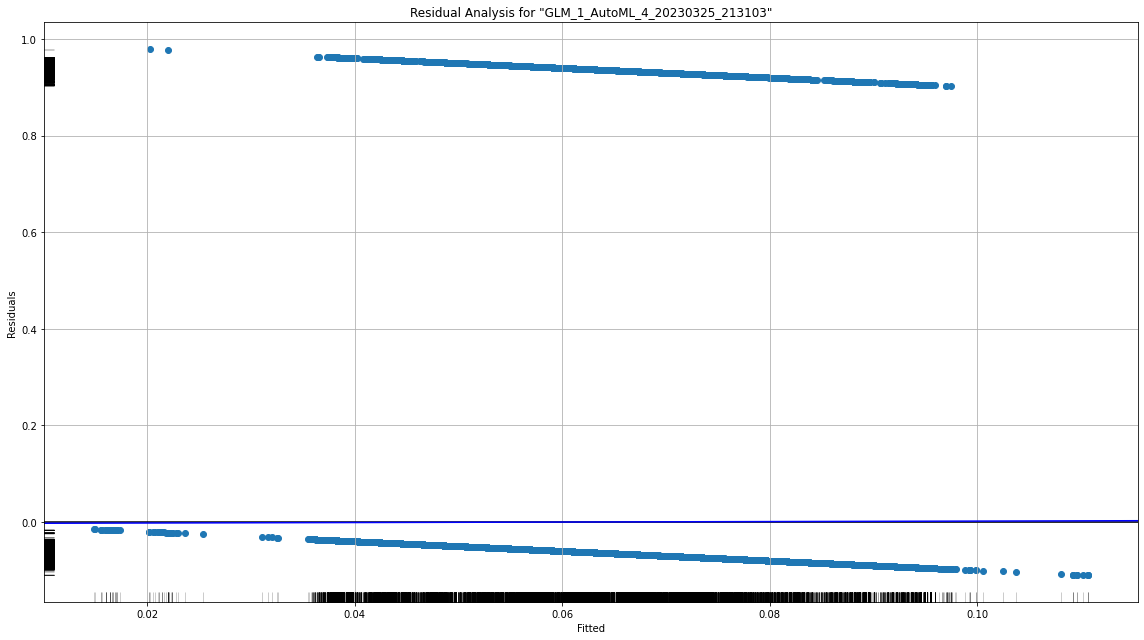

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

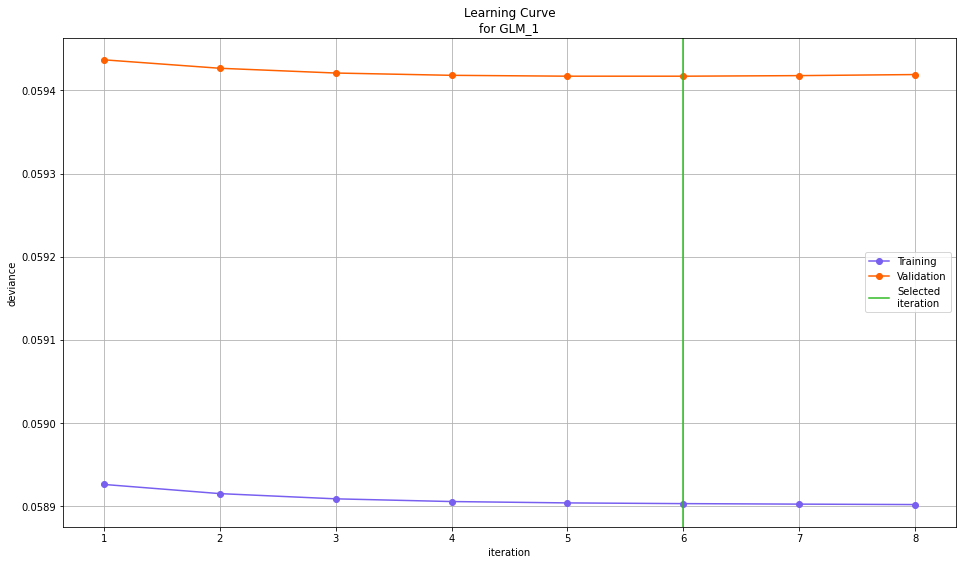

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

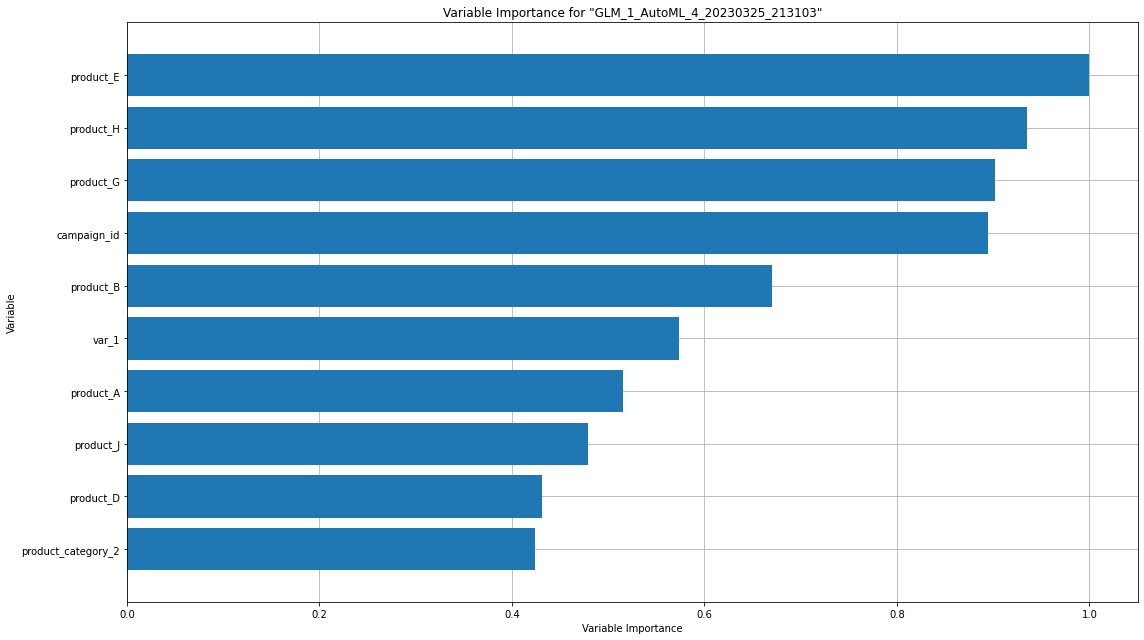

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

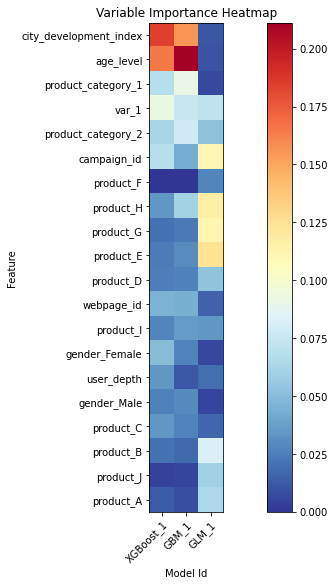

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

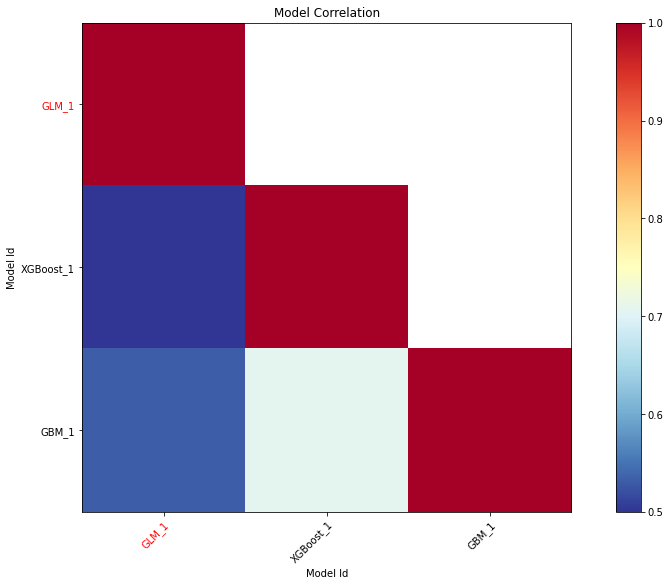

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

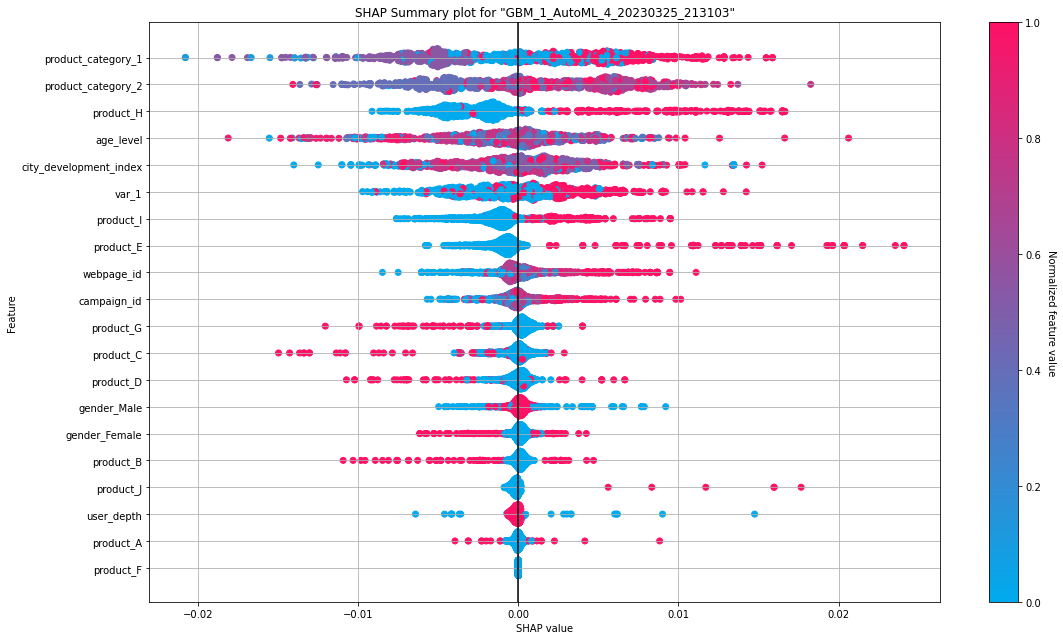

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

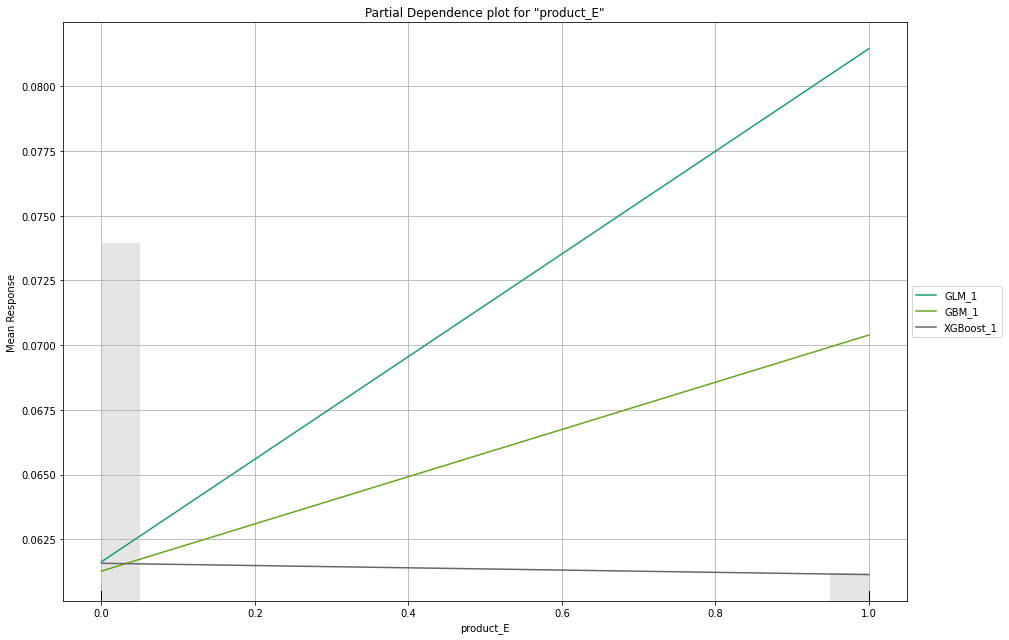

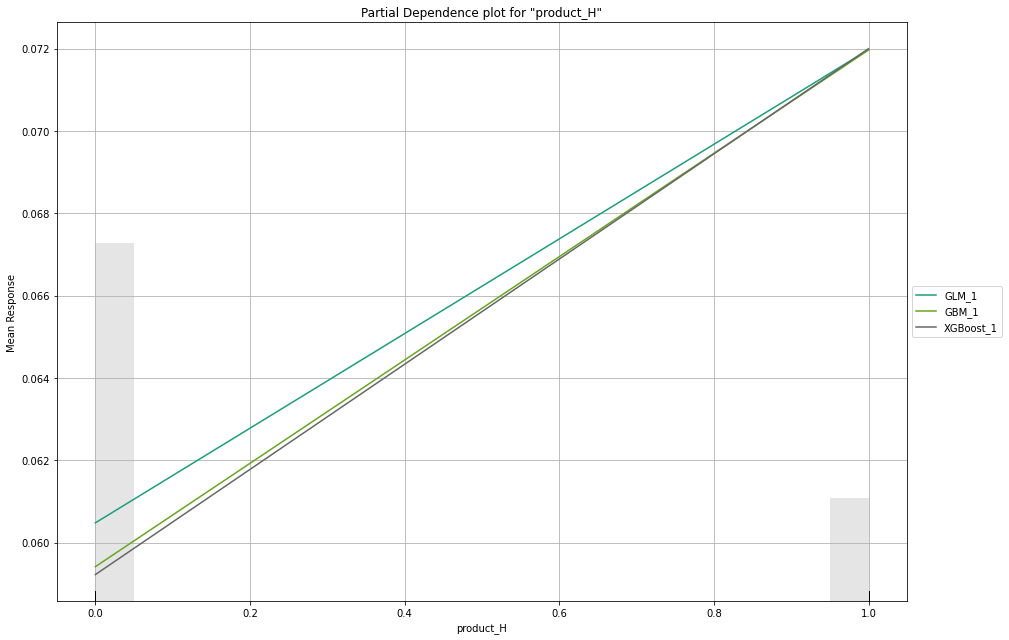

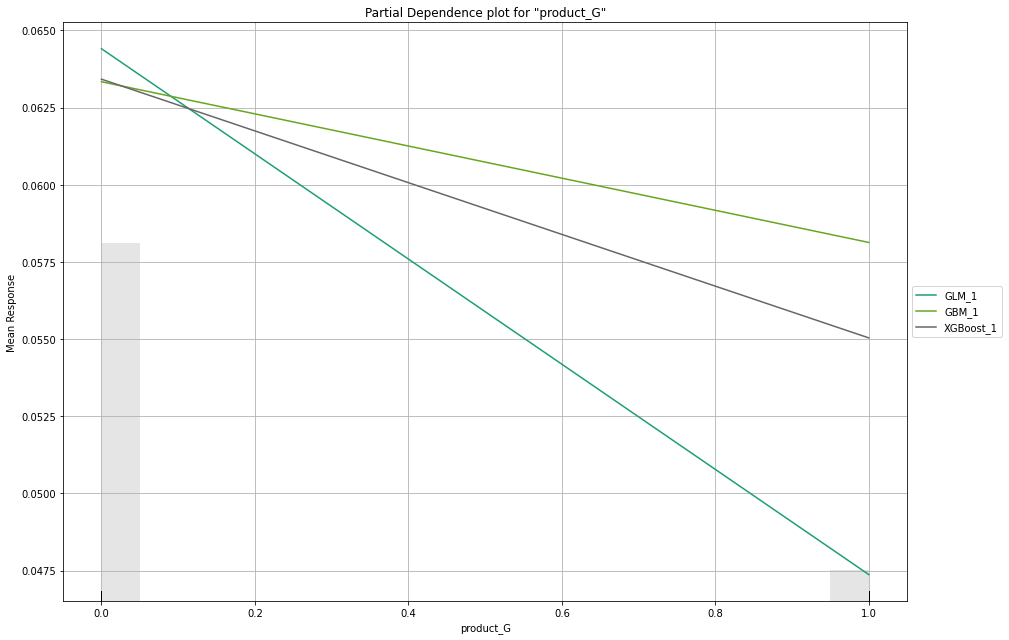

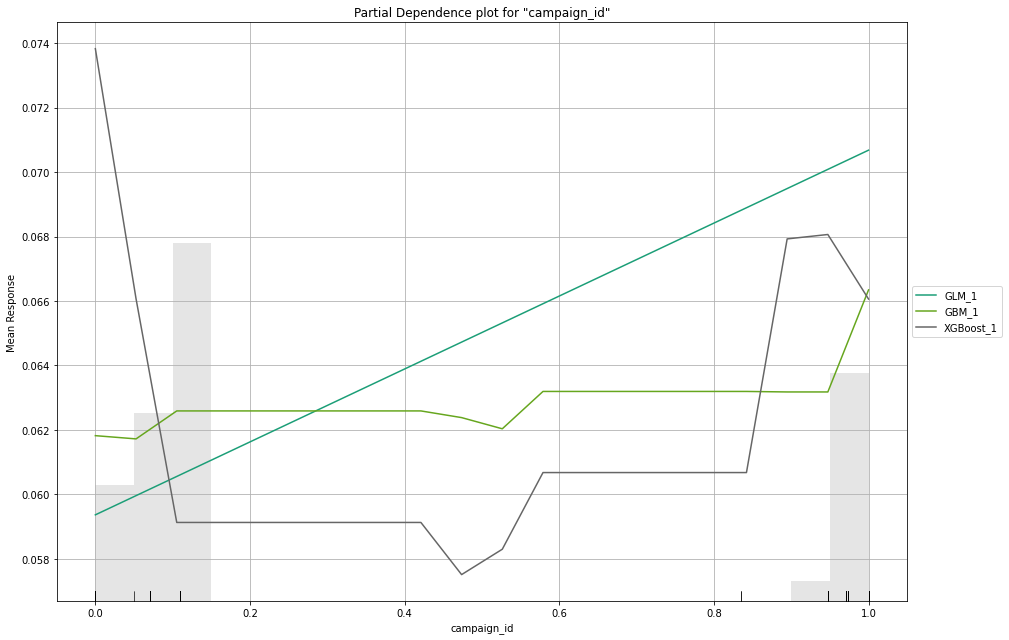

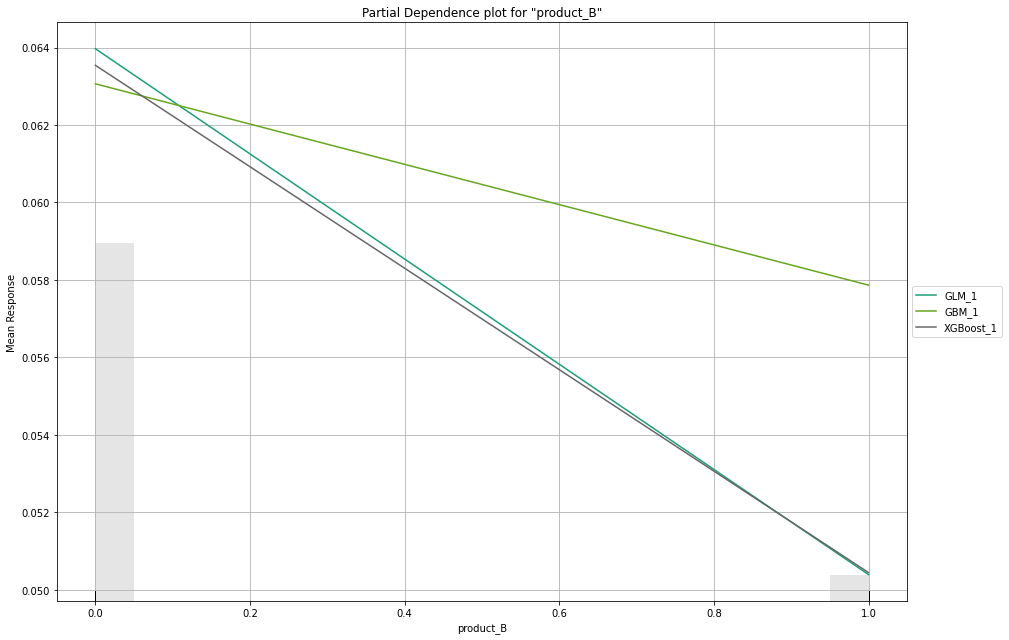

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

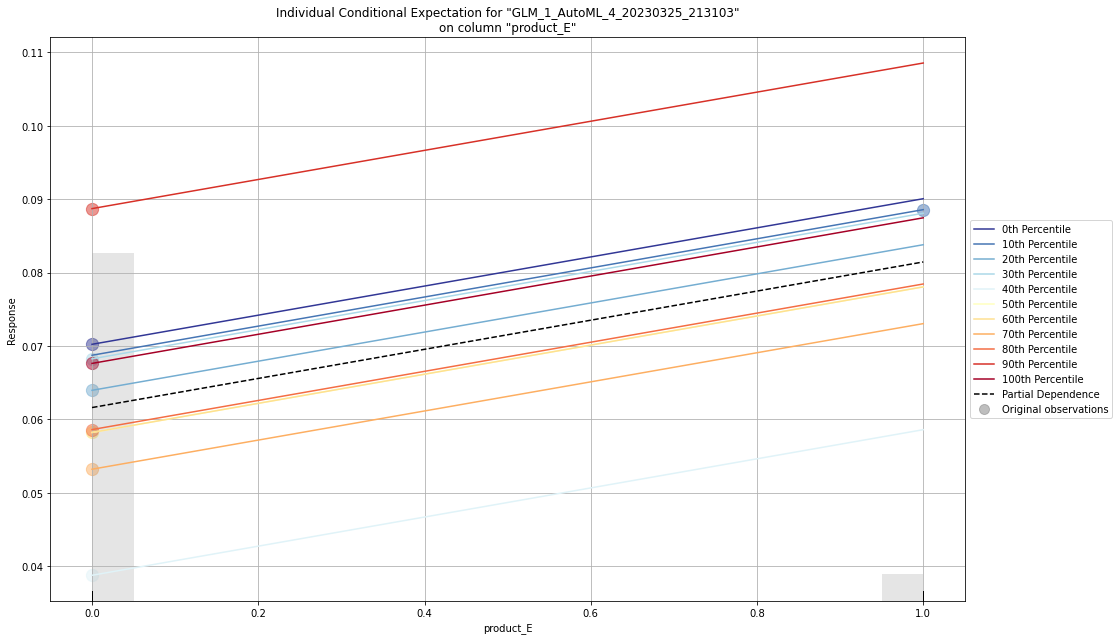

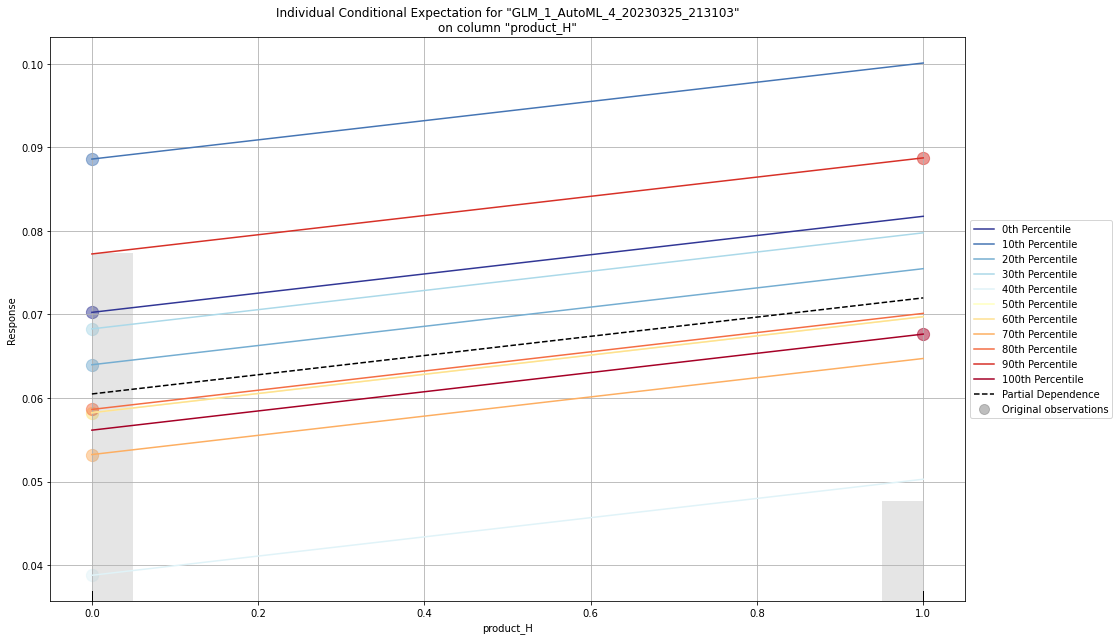

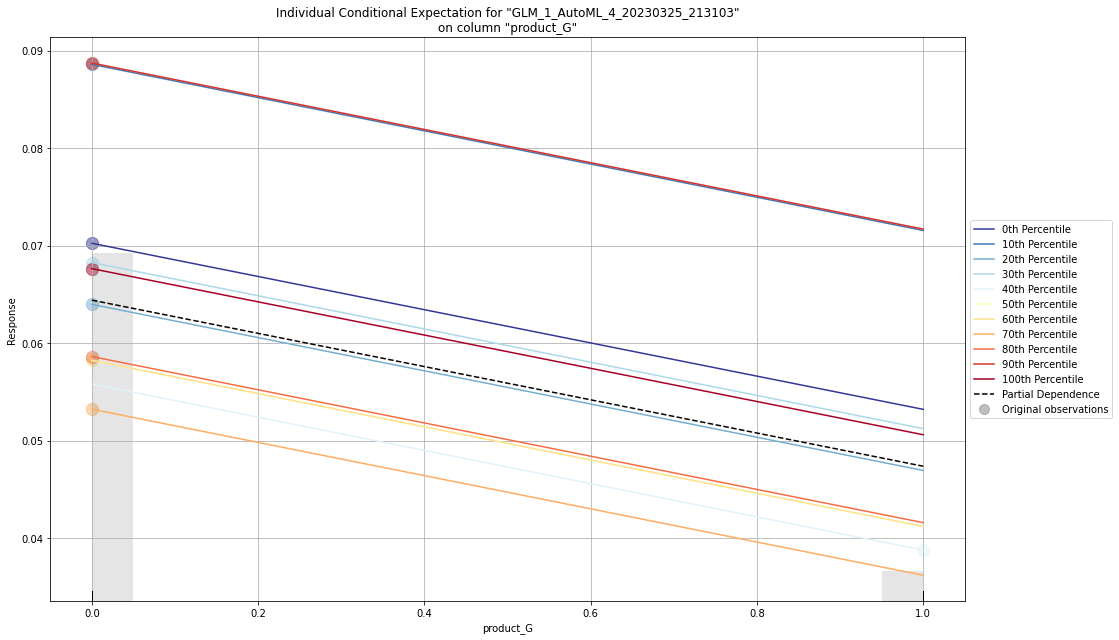

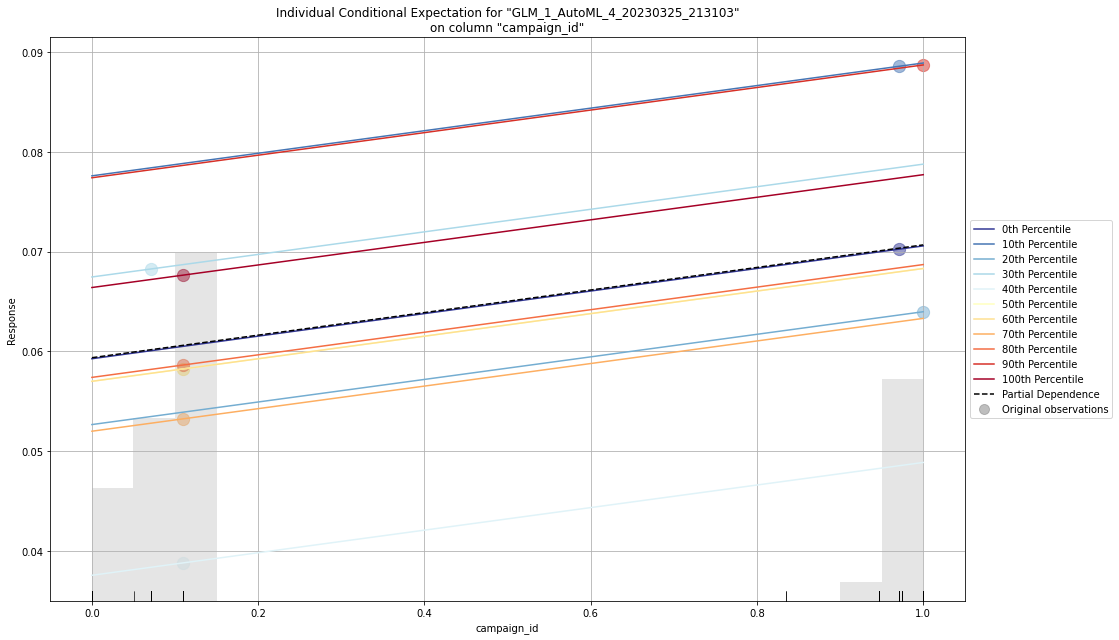

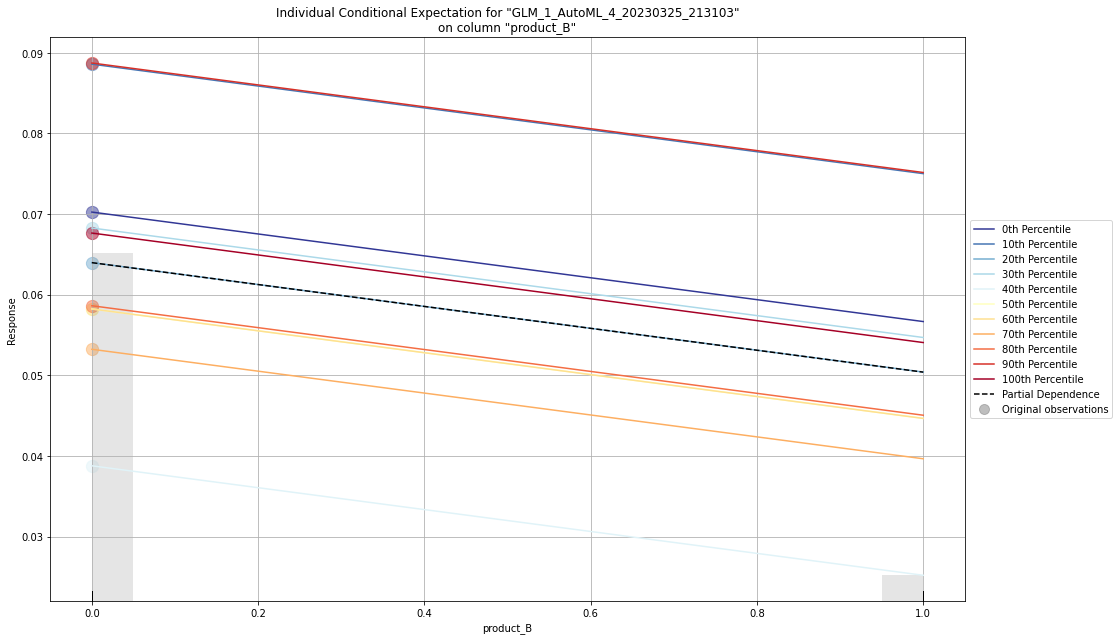



H2OExplanation([('leaderboard', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7f236be2cca0>), ('description', <h2o.explanation._explain.Description object at 0x7f236bee8310>), ('data', H2OFrame({'_ex': <Expr(makeLeaderboard ['GLM_1_AutoML_4_20230325_213103', 'GBM_1_AutoML_4_20230325_213103', 'XGBoost_1_AutoML_4_20230325_213103'] 'Key_Frame__upload_bc8c798e5975f171224a1ddfcf084ce3.hex' 'AUTO' 'ALL' 'AUTO')#py_9_sid_805b>}))])), ('residual_analysis', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7f236bee8af0>), ('description', <h2o.explanation._explain.Description object at 0x7f236bee8eb0>), ('plots', H2OExplanation([('GLM_1_AutoML_4_20230325_213103', <h2o.plot._plot_result._MObject object at 0x7f236f1876a0>)]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7f2371e98520>), ('description', <h2o.explanation._explain.Description object at 0x7f2371e98250>), ('plots', H2OExplanation([('GLM_1

In [31]:
# generates an explanation of the H2OAutoML object 'aml' using the H2OFrame object
from h2o import explanation
explanation = aml.explain(dtrain_h2o)
print(explanation)

## Shap Analysis for Logistic Regression and Tree

### 1) Shap Explainer

In [32]:
#computes the SHAP values of the features for each observation in 'xtrain_2000' using a SHAP explainer object 'explainer' based on the model's predict function
explainer = shap.Explainer(model.predict, xtrain_1000, seed=10)
linear_shap_values = explainer(xtrain_1000)

Permutation explainer: 1001it [00:26, 25.27it/s]                         


In [33]:
#computes the SHAP values of the features for each observation in 'xtrain_2000' using a SHAP explainer object 'explainer1' based on the predict function of a decision tree classifier named 'model1'
explainer = shap.Explainer(model.predict, xtrain_1000, seed=10)
tree_shap_values = explainer(xtrain_1000)

Permutation explainer: 1001it [00:23, 23.84it/s]                         


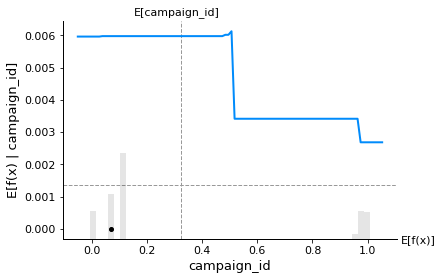

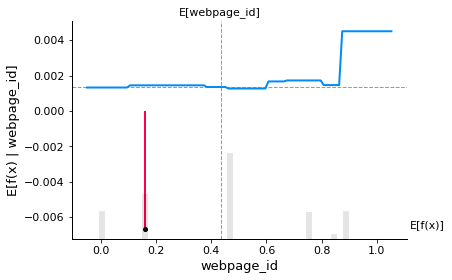

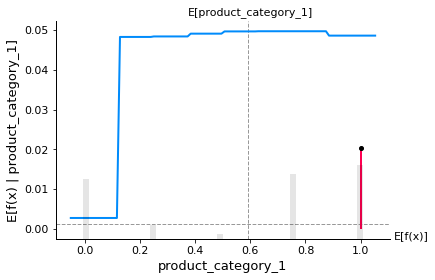

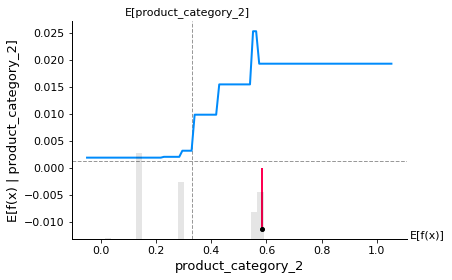

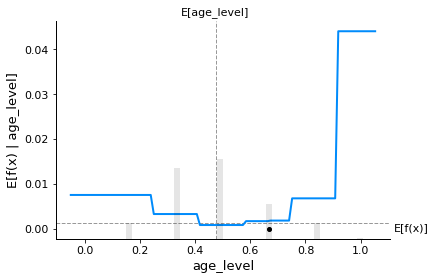

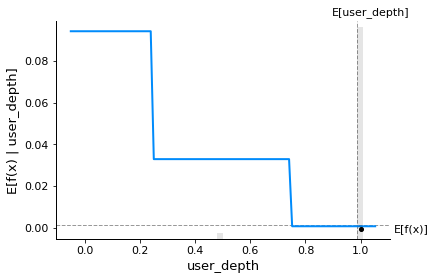

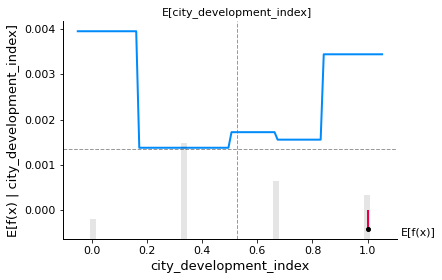

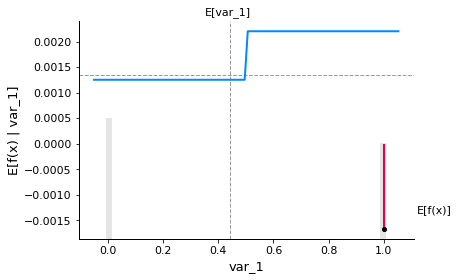

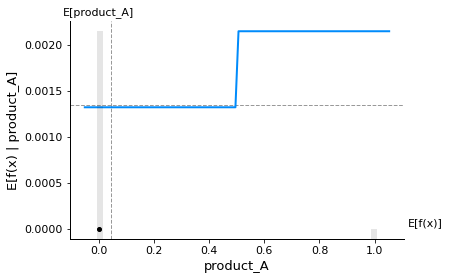

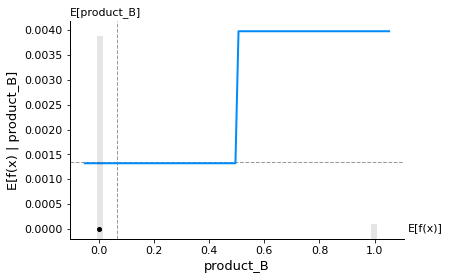

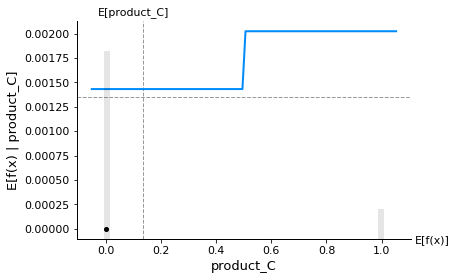

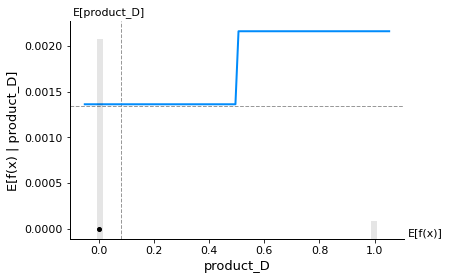

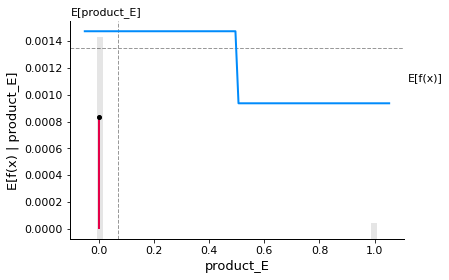

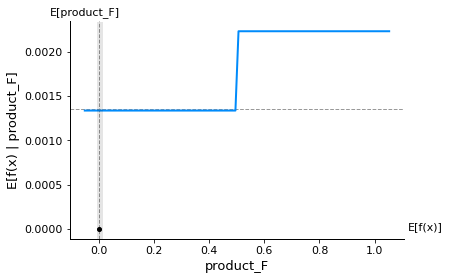

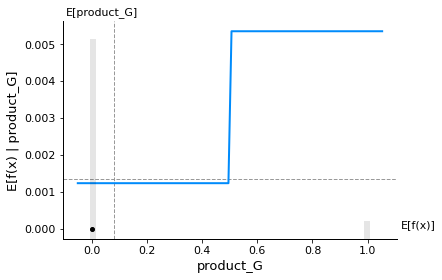

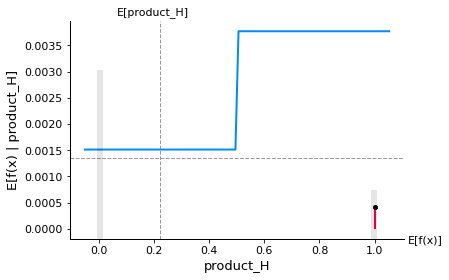

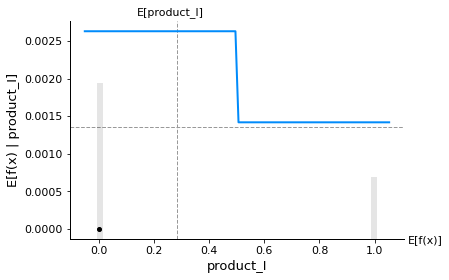

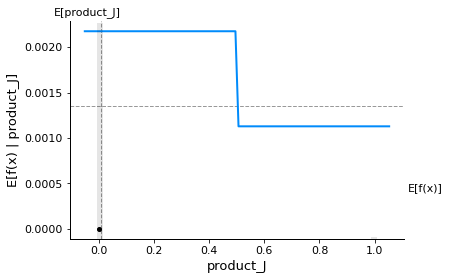

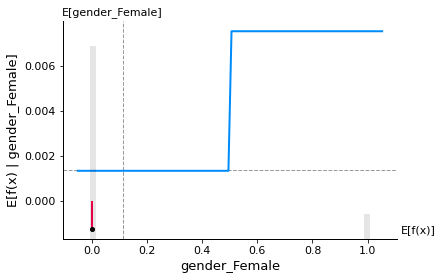

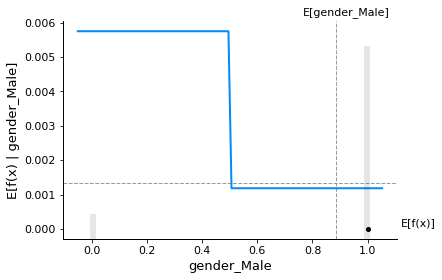

In [34]:
#generates a partial dependence plot for each feature in 'xtrain.columns' using the SHAP values of the linear model 'model.predict' for a single observation 'sample_ind'
# which is subsetted from 'linear_shap_values', with respect to the selected feature
for i in xtrain.columns:
    sample = 10
    shap.partial_dependence_plot(
        i,
        model.predict,
        xtrain,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=linear_shap_values[sample : sample + 1, :],
    )   

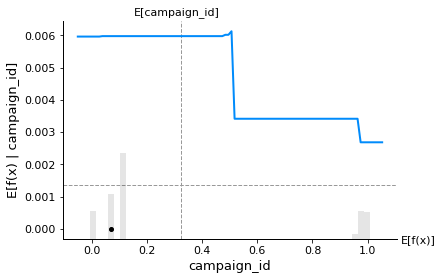

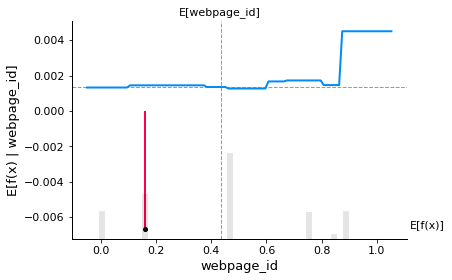

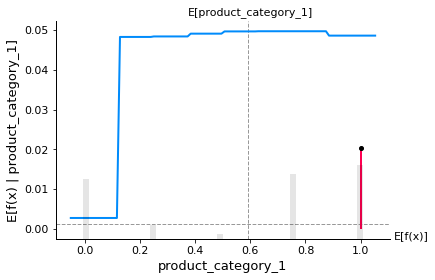

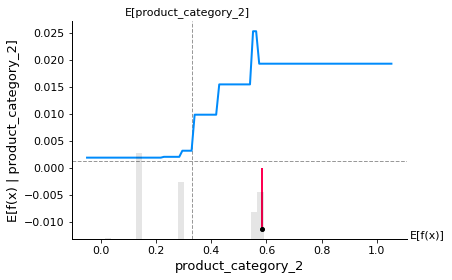

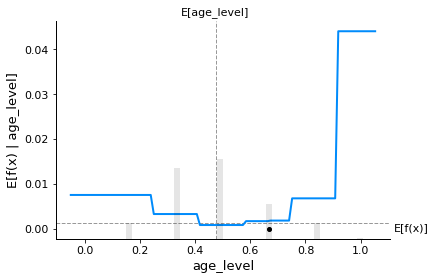

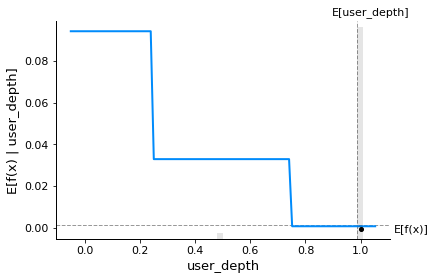

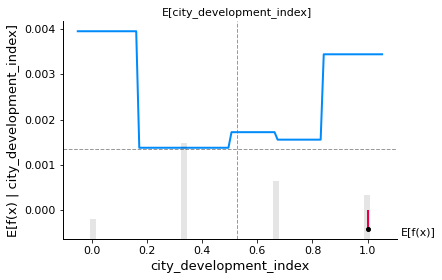

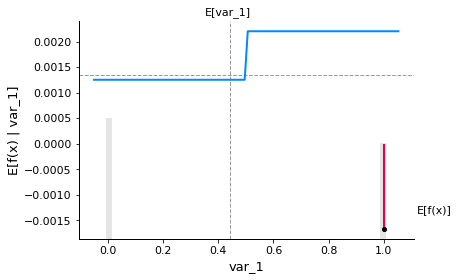

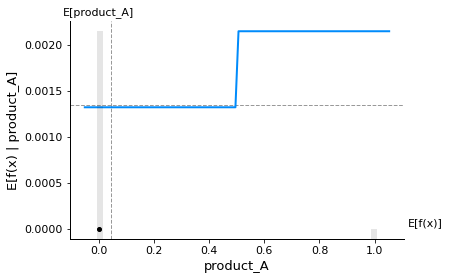

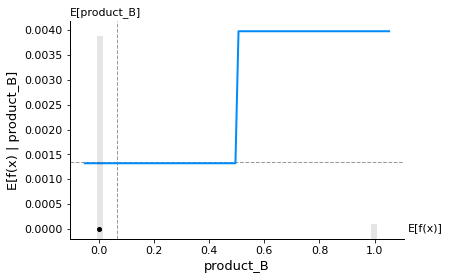

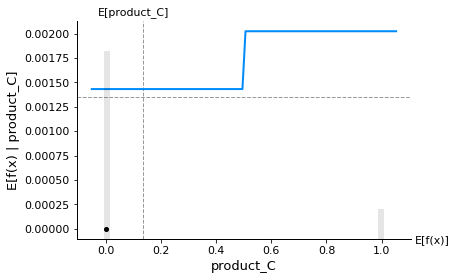

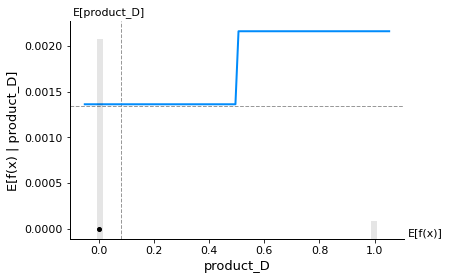

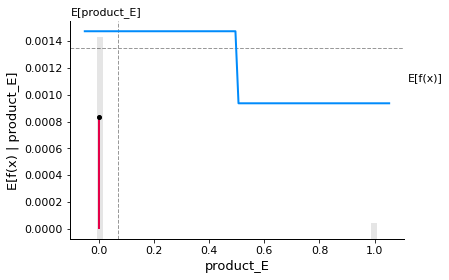

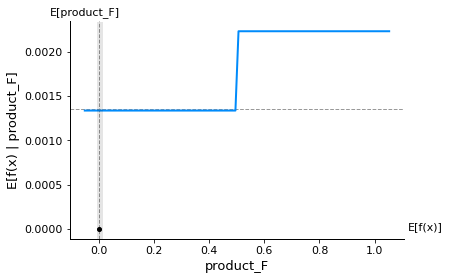

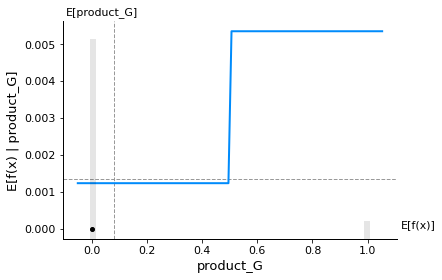

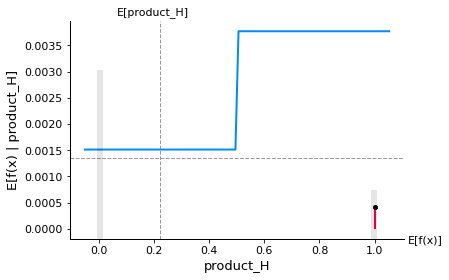

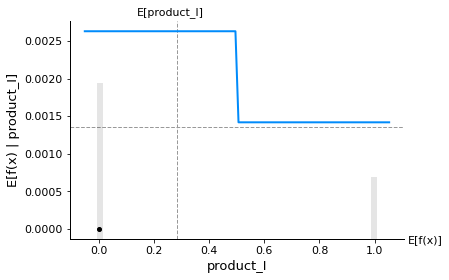

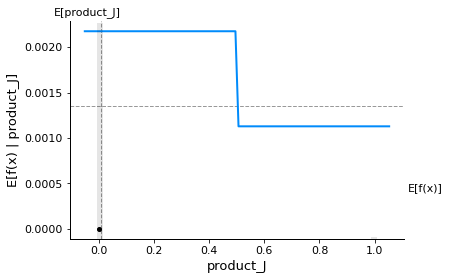

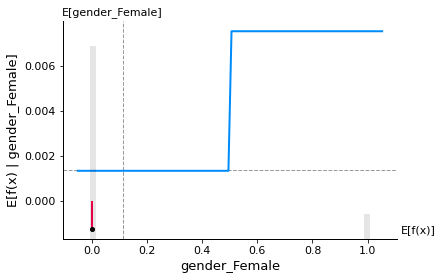

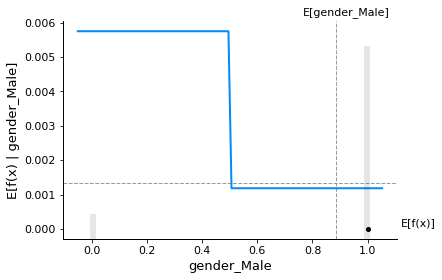

In [35]:
#generates a partial dependence plot for each feature in 'xtrain.columns' using the SHAP values of the decision tree classifier 'model1.predict' for a single observation 'sample_ind',
# which is subsetted from 'tree_shap_values', with respect to the selected feature.
for i in xtrain.columns:
    sample_ind = 18
    shap.partial_dependence_plot(
        i,
        model.predict,
        xtrain,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=tree_shap_values[sample : sample + 1, :],
    )  

### 2) Beeswarm Analysis

A beeswarm plot is a way to visualize the distribution of Shapley Values for each feature in a machine learning model. In a beeswarm plot, each dot represents a single instance in the dataset, and the position of the dot on the x-axis represents the Shapley Value for the corresponding feature. The dots are arranged in a way that minimizes overlap, so that it is easy to see the distribution of values.

The beeswarm plot is useful for identifying which features have the most impact on the model's predictions, and for detecting interactions between features. Features with a large range of Shapley Values indicate that they have a significant impact on the model, while features with a small range of Shapley Values indicate that they have less impact.

In summary, the beeswarm plot is a visualization tool that is used to explain the contribution of individual features to a machine learning model's predictions using the Shapley Value concept from cooperative game theory.

User Gender Male is the most important factor in for Logistic Regression while Product Category 1 is the most important for tree value

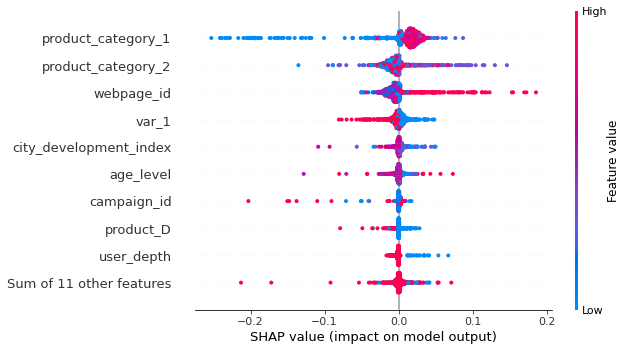

In [36]:
#generates a beeswarm plot to display the distribution of SHAP values for each feature in 'linear_shap_values'.
shap.plots.beeswarm(linear_shap_values, show=False)

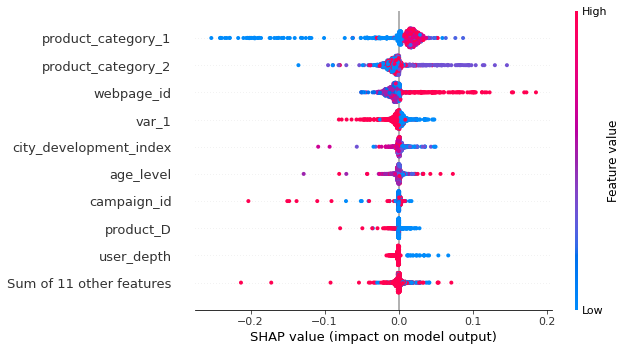

In [37]:
# creates a bee swarm plot to visualize the Tree SHAP values
shap.plots.beeswarm(tree_shap_values, show=False)

In [38]:
print(len(xtrain))

72660


### 3) Heatmap Analysis

A Shap heatmap is a visualization tool used in machine learning to display the contribution of each feature in a dataset towards the prediction of a target variable. It is based on the SHAP (SHapley Additive exPlanations) values, which is a method for explaining the output of any machine learning model.

The SHAP values represent the contribution of each feature to the difference between the predicted output and the average output of the model. Positive SHAP values indicate that a feature contributes to increasing the predicted output, while negative SHAP values indicate that a feature contributes to decreasing the predicted output.

To create a Shap heatmap, first, the SHAP values for each instance in the dataset are calculated. Then, the absolute SHAP values for each feature are averaged across all instances, and the result is plotted as a heatmap where each row represents a feature, and each column represents an instance. The color of each cell in the heatmap represents the magnitude of the SHAP value for that feature and instance.

Shap heatmaps can be helpful in identifying which features are most important in determining the output of a machine learning model and how these features interact with each other. They can also be used to detect any patterns or correlations between features that may be useful for further analysis.

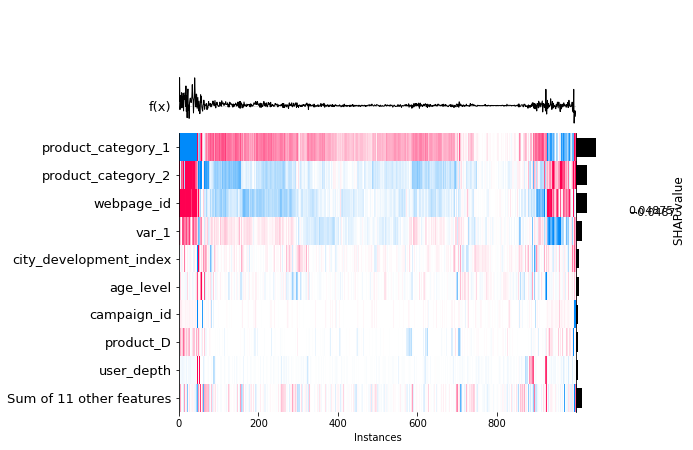

In [39]:
#creates a heatmap plot to visualize the Linear SHAP values.
shap.plots.heatmap(linear_shap_values)

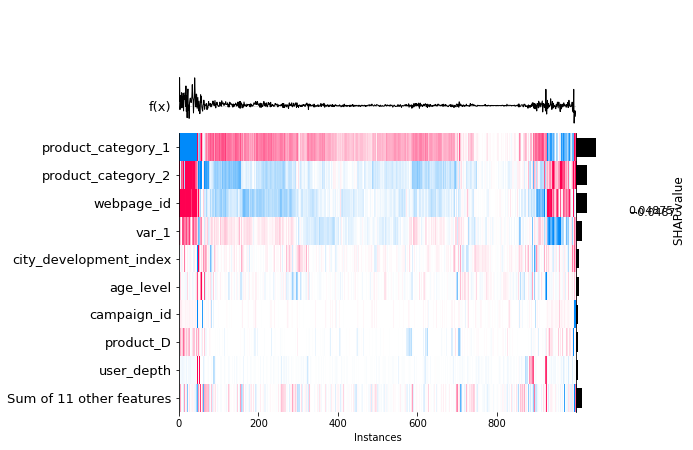

In [40]:
#creates a heatmap plot to visualize the Tree SHAP values.
shap.plots.heatmap(tree_shap_values)

### 4) Bar Plot Analysis

A Shapley value plot, also known as a Shap plot, is a visualization technique used to explain how individual features contribute to a model's prediction for a specific instance. A Shap bar plot is a type of Shap plot that displays the feature importance values as vertical bars.

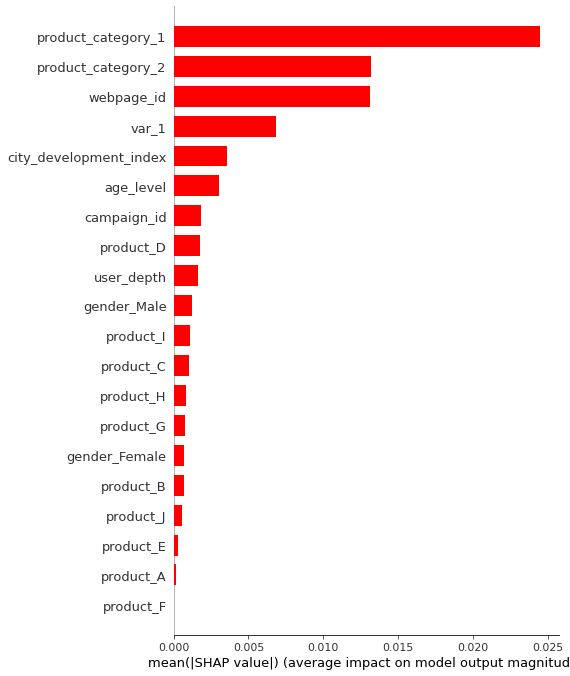

In [41]:
#creates a summary plot to visualize the feature importance of the Linear SHAP values using a bar chart with a blue color scheme.
shap.summary_plot(linear_shap_values, xtrain, plot_type="bar", color="red")

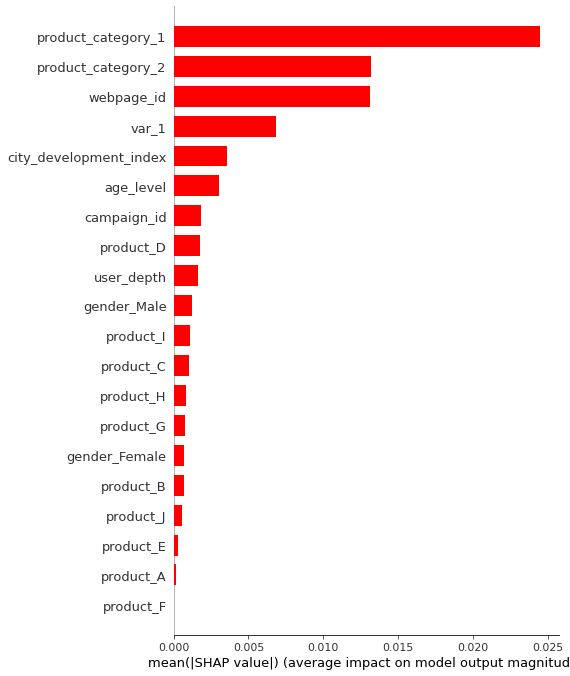

In [42]:
# creates a summary plot to visualize the feature importance of the Tree SHAP values using a bar chart with a red color scheme.
shap.summary_plot(tree_shap_values, xtrain, plot_type="bar", color="red")

### 5) Waterfall Analysis

SHAP (SHapley Additive exPlanations) waterfall plot is a visualization tool that helps to explain the output of a machine learning model by decomposing the contribution of each feature to the final prediction. The SHAP waterfall plot shows how each feature value affects the model's output compared to a baseline value.

Here's how to interpret a SHAP waterfall plot:

The top of the plot represents the total output value of the model for a given instance.
Each row represents the contribution of a feature to the model's output value.
The length of each bar represents the magnitude of the feature's effect on the output.
Positive values are shown in blue and negative values in red.
The baseline value is represented by the vertical dashed line in the middle of the plot.
With a SHAP waterfall plot, you can easily see which features have the greatest impact on the model's output, and in which direction (positive or negative). This can be helpful for model interpretability and feature selection.

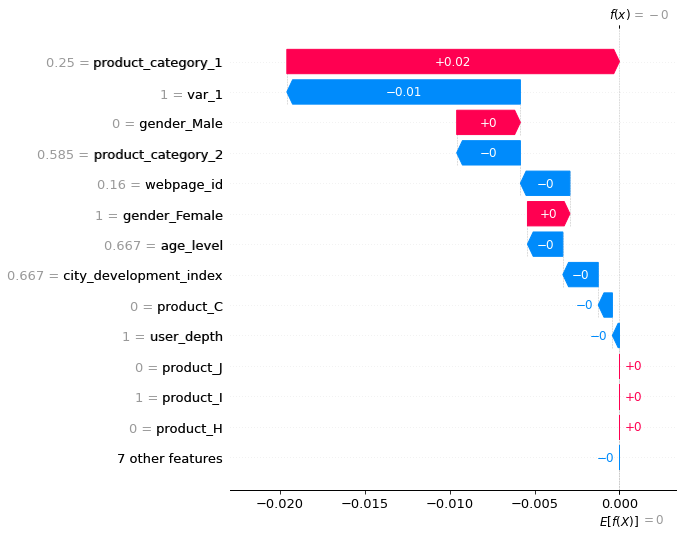

In [43]:
 # creates a waterfall plot to visualize the contributions of each feature to the prediction for a specific sample using the Linear SHAP values, displaying up to 14 features.
shap.plots.waterfall(linear_shap_values[sample_ind],max_display=14)

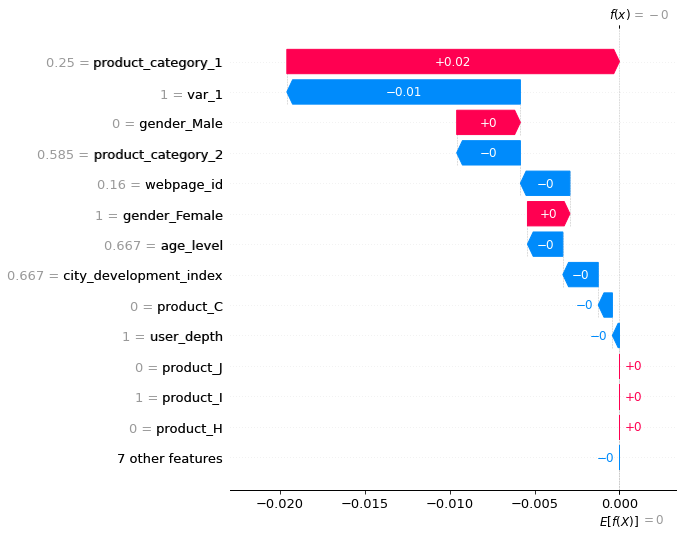

In [44]:
#creates a waterfall plot to visualize the contributions of each feature to the prediction for a specific sample using the Tree SHAP values, displaying up to 14 features.
shap.plots.waterfall(tree_shap_values[sample_ind], max_display=14)

## Partial Dependence Plot

A Shapley partial dependence plot (PD plot) shows how the predicted outcome of a machine learning model changes as the values of a selected feature(s) change while holding all other features constant. It consists of a partial dependence function (PDF) and individual conditional expectation (ICE) plots. The PDF shows the average predicted outcome while the ICE plots show the predicted outcome for individual samples. It helps identify non-linear relationships and gain insights into how the model is making predictions.

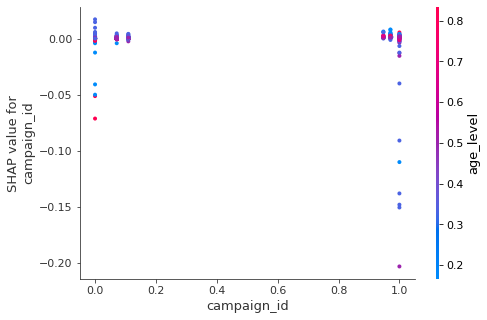

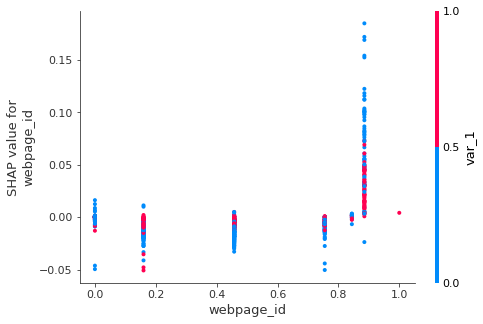

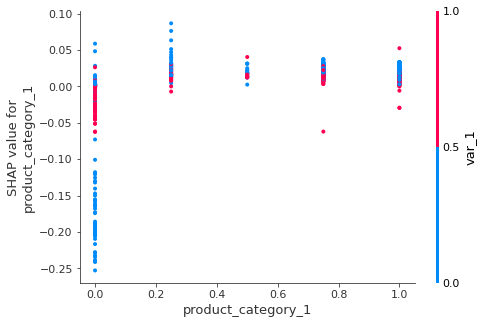

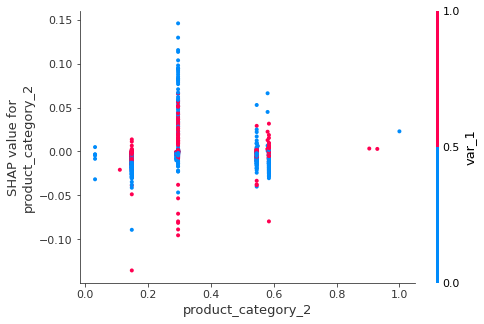

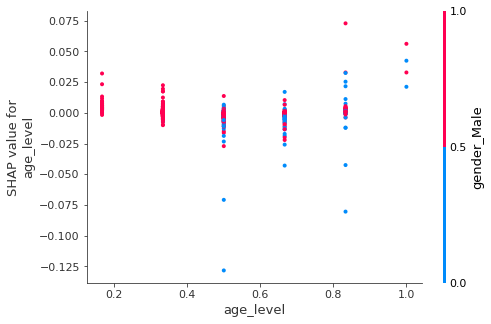

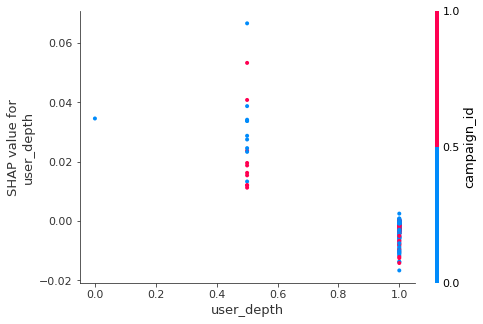

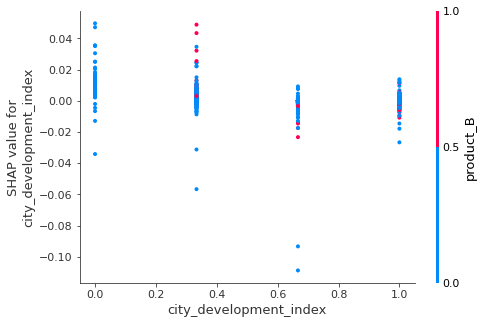

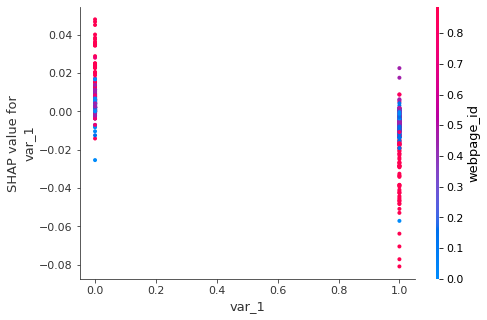

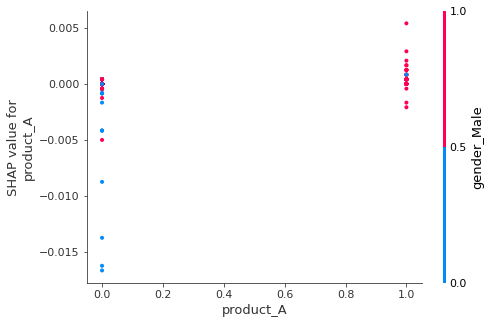

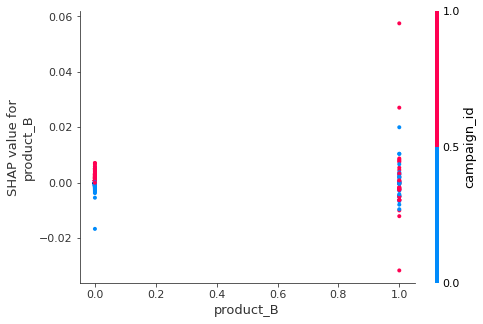

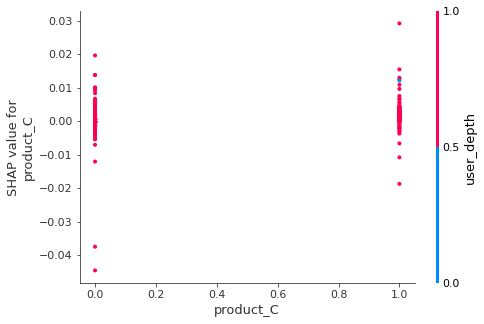

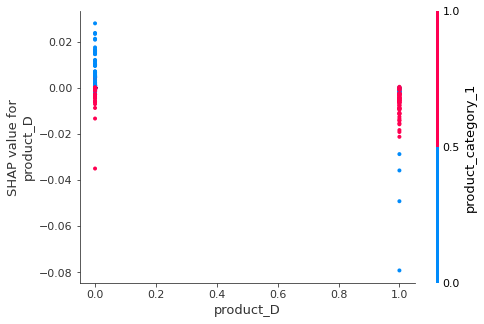

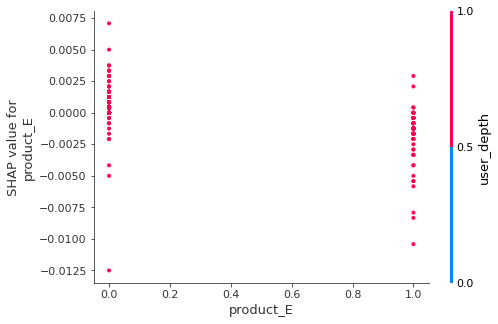

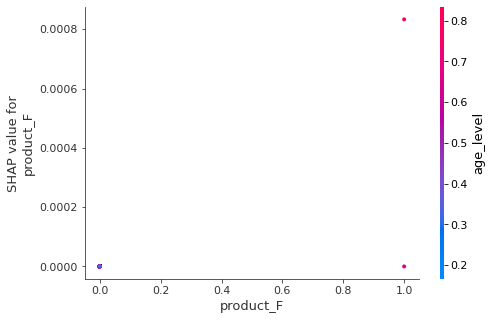

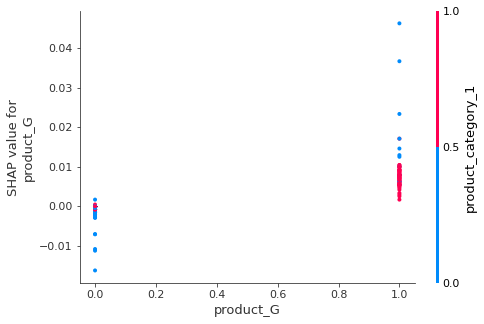

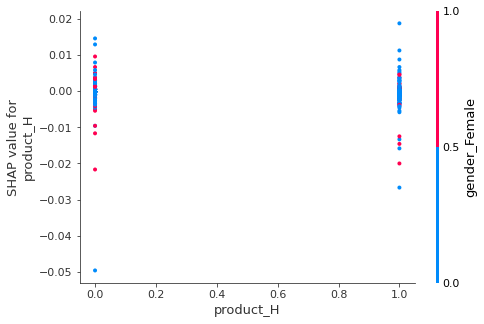

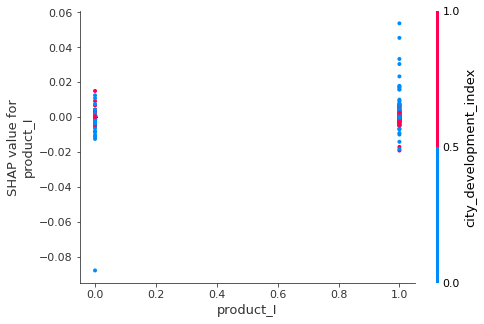

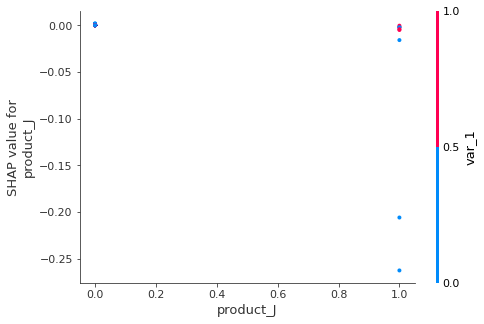

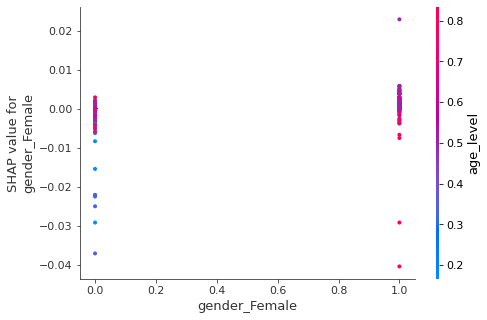

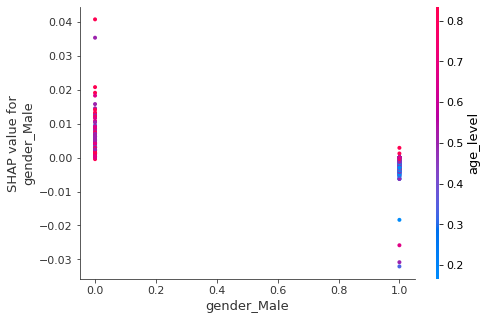

In [45]:
#creates dependence plots to visualize the relationship between each feature and its corresponding Linear SHAP values for a dataset of 2000 samples.
for i in xtrain.columns:
    shap.dependence_plot(i, linear_shap_values.values, xtrain_1000)

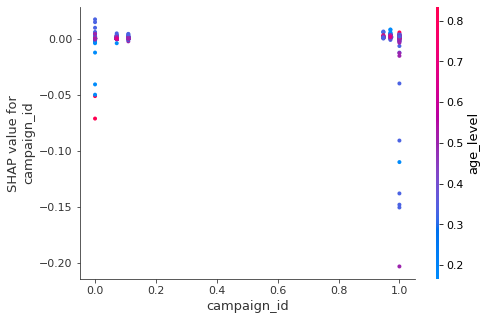

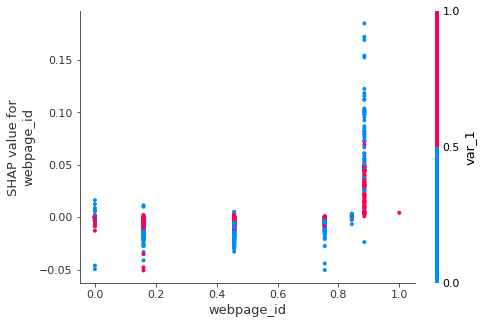

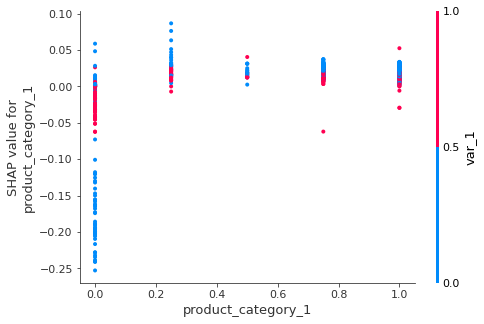

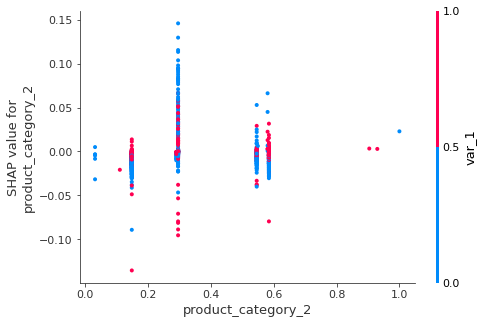

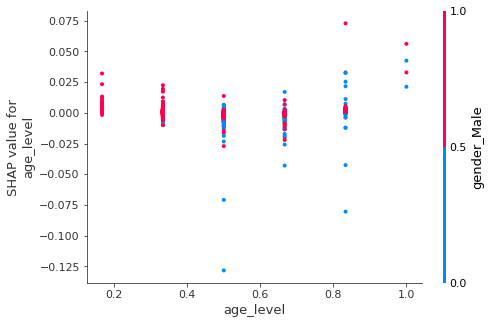

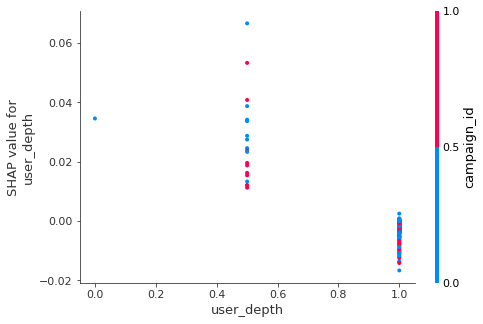

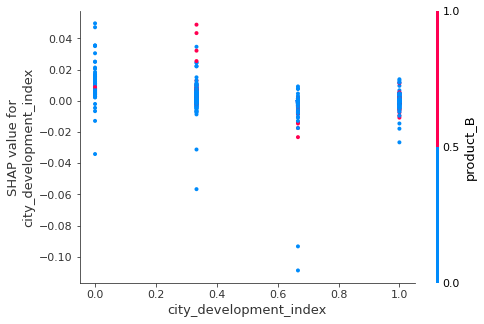

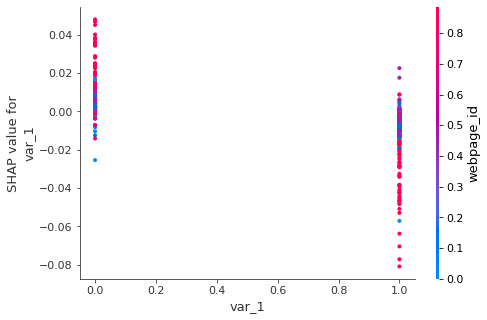

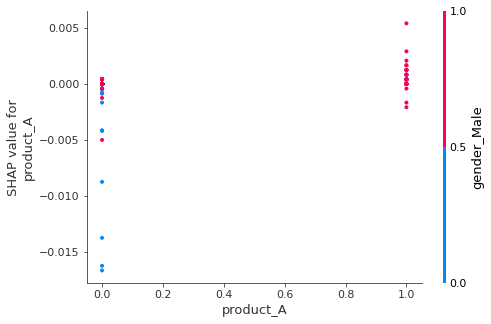

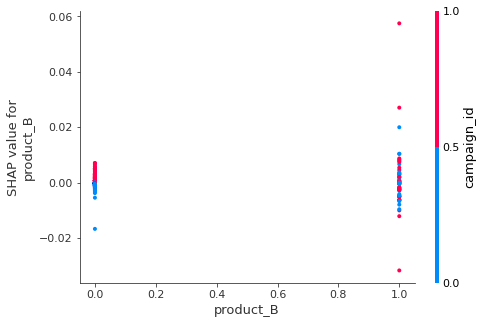

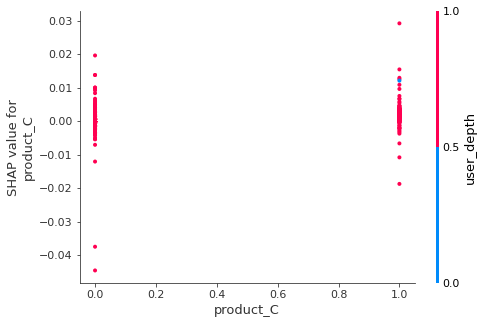

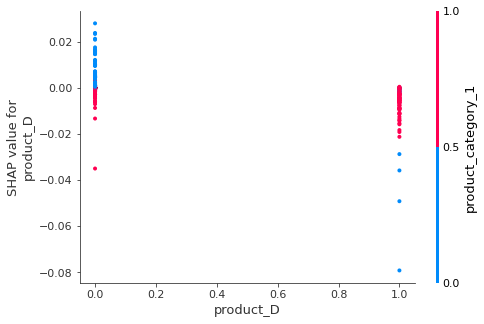

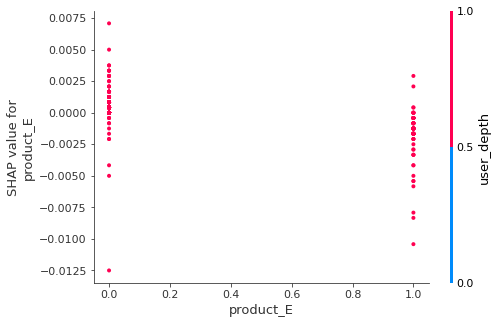

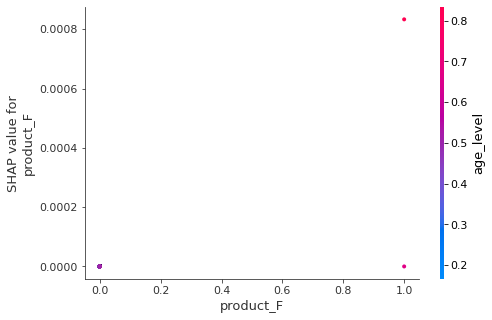

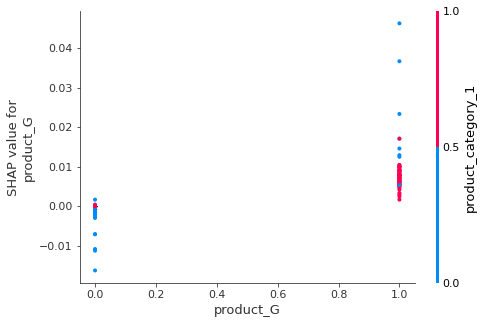

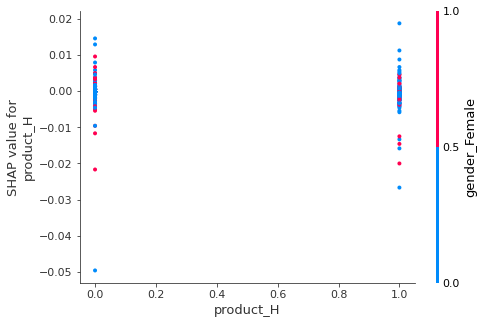

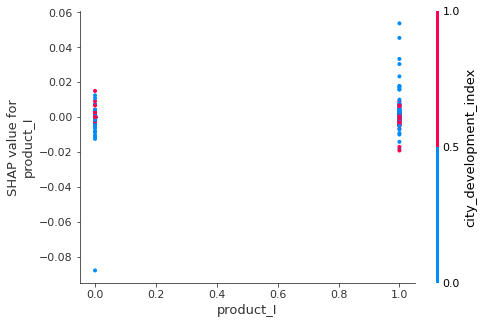

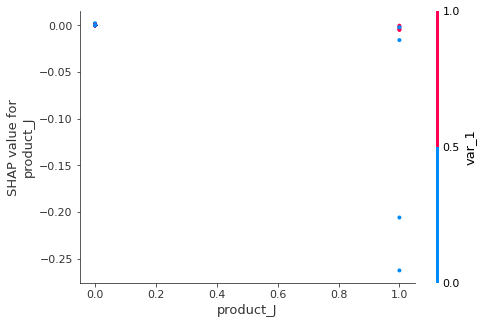

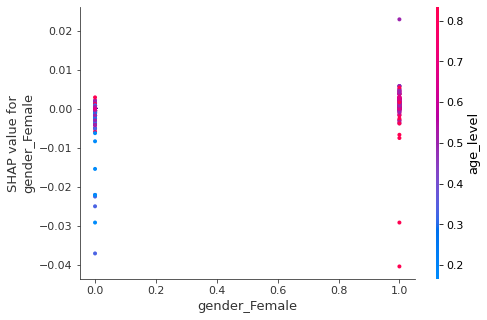

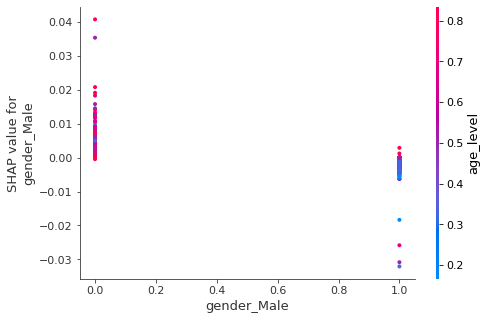

In [46]:
#creates dependence plots to visualize the relationship between each feature and its corresponding Tree SHAP values for a dataset of 2000 samples.
for i in xtrain.columns:
    shap.dependence_plot(i, tree_shap_values.values, xtrain_1000)

# References

* Scikit-learn official documentation: https://scikit-learn.org/stable/modules/preprocessing.html
* Shap official documentation: https://shap.readthedocs.io/en/latest/index.html
* Pandas official documentation: https://pandas.pydata.org/docs/user_guide/index.html
* "Data Preprocessing for Machine Learning with Python" by Selva Prabhakaran on KDnuggets: https://www.kdnuggets.com/2020/03/data-preprocessing-machine-learning-python.html
* "Data Preprocessing for Logistic Regression in Python" by Michael Galarnyk on Medium: https://towardsdatascience.com/data-preprocessing-for-logistic-regression-in-python-c632418098b0

# Conclusion


The choice of an interpretable method for machine learning models depends on the specific needs and trade-offs between accuracy and interpretability. LIME and SHAP are popular methods for interpreting black-box models, with LIME being lightweight and suitable for some use cases, and SHAP being more stable and theoretically sound but requiring more computational resources. PDP and SHAP differ in their approach to analyzing variable contributions to the output. PDP is useful for understanding the effect of a single variable on the output, while SHAP shows the contribution of each variable to the output. Ultimately, the best method will depend on the specific goals and requirements of the project at hand.

# Copyright 2023 Rhea Bajpai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.